# 1. Tutorial on using the Tidymodels Framework in Datacamp Workspace
The tidyverse is a series of packages for R that share an underlying design philosophy. The tidymodels framework is a nice way to perform fitting and modeling in a convenient bundled way. However, I found it somewhat confusing to implement the more complicated aspects of the method. Implementation was also more difficult because certain commands found in many online tutorials caused Datacamp Workspace and Kaggle to crash or timeout without error messaging (as of Feb 23, 2023). These calls are handled (more) cleanly by R Studio. It took me a long time to figure out the problem, so I thought a detailed tutorial on how I got this to work would be helpful for other learners. There are comments by the lines of code that fail on Kaggle, Datacamp, or both. If they cause Datacamp workspace to time out, they are commented out here, but if you run this code in RStudio, you might want to put them back in.

I also spent a fair amount of time making figures and tables that I found both aesthetically pleasing and accessible to those with visual impairments such as low vision or color blindness.

I heavily relied on the tutorials at https://juliasilge.com/ and the book [Tidy Modeling with R](https://www.tmwr.org/). I will link more specific references in the relevant sections.

I will walk through a classification problem from importing the data, cleaning, exploring, fitting, choosing a model, and finalizing the model. The specific problem is one provided by Datacamp as a challenge in the certification community. The dataset (Credit Card Fraud) can also be found at the Datacamp workspace.  

In addition to the narrative in the markdown blocks, there will be extensive commenting in the code blocks to assist in understanding what I'm doing. I've also manually numbered each code block in the first comment, making it easier to reference earlier code.

Please feel free to copy and use any of my code in your work. I'd appreciate an acknowledgment or link back if you find this tutorial useful.

## 1.1 Outline of Code Blocks
1. Code Block 1: Installing Packages
2. Code Block 2: Loading Libraries
3. Code Block 3: Setting Global Figure Options
4. Code Block 4: Reading in the Data
5. Code Block 5: Validation of Data Types Against Data Dictionary
6. Code Block 6: Converting Strings to Factors
7. Code Block 7: Exploring the Compactness of the Categories
8. Code Block 8: Exploring the Category factor
9. Code Block 9: Removing Character/ String Variables
10. Code Block 10: Comparing Merchant and Transaction Locations
11. Code Block 11: Removing merch_lat and merch_long
12. Code Block 12: Looking at Fraud by Location
13. Code Block 13: Converting city/state data lat/long
14. Code Block 14: Distance Between Home and Transaction
15. Code Block 15: Distance from Home and Fraud
16. Code Block 16: Remove Extraneous/Temp Variables
17. Code Block 17: Looking at dob
18. Code Block 18: Removing dob
19. Code Block 19: Looking at Transaction Date/ Times
20. 

In [2]:
install.packages('bonsai')

# Code Block 1: Installing Packages

#Packages for visualizations
install.packages('corrplot') # makes a nice correlation plot
install.packages('cowplot') # allows for the creating of multi-panel plots
install.packages('ggthemes') # more themes for ggplot
install.packages('viridis') #color scales for color-blind friendly graphs

#Packages for modeling
install.packages('glmnet')  # needed for elastic net logistic regression
install.packages('ranger')  # for random forest
install.packages('lightgbm')
install.packages('vip')
# Packages for geospatial data
install.packages('tidygeocoder')  # used here to convert cuty/state to lat/long


Installing bonsai [0.2.1] ...
	OK [linked cache]
Installing corrplot [0.92] ...
	OK [linked cache]
Installing cowplot [1.1.1] ...
	OK [linked cache]
Installing ggthemes [4.2.4] ...
	OK [linked cache]
Installing viridis [0.6.2] ...
	OK [linked cache]
Installing glmnet [4.1-7] ...
	OK [linked cache]
Installing ranger [0.15.1] ...
	OK [linked cache]
Installing lightgbm [3.3.5] ...
	OK [linked cache]
Installing vip [0.3.2] ...
	OK [linked cache]
Installing tidygeocoder [1.0.5] ...
	OK [linked cache]


In [3]:
# Code Block 2: Loading Libraries

# everything is wrapped in suppressPackageStartupMessages to supress messaging as the packages are # loaded

# loading tidyverse/ tidymodels packages
suppressPackageStartupMessages(library(tidyverse)) #core tidyverse
suppressPackageStartupMessages(library(tidymodels)) # tidymodels framework
suppressPackageStartupMessages(library(lubridate)) # date/time handling

# visualization
suppressPackageStartupMessages(library(viridis)) #color scheme that is colorblind friendly
suppressPackageStartupMessages(library(ggthemes)) # themes for ggplot
suppressPackageStartupMessages(library(gt)) # to make nice tables
suppressPackageStartupMessages(library(cowplot)) # to make multi-panel figures
suppressPackageStartupMessages(library(corrplot)) # nice correlation plot

#Data Cleaning
suppressPackageStartupMessages(library(skimr)) #provides overview of data and missingness

#Geospatial Data
suppressPackageStartupMessages(library(tidygeocoder)) #converts city/state to lat/long

#Modeling
suppressPackageStartupMessages(library(ranger)) # random forest
suppressPackageStartupMessages(library(glmnet)) # elastic net logistic regression
suppressPackageStartupMessages(library(themis)) # provides up/down-sampling methods for the data
suppressPackageStartupMessages(library(lightgbm)) # fast gradient-boosted machine algo
suppressPackageStartupMessages(library(bonsai)) #provides parnsip objects for tree-based models

# 2. The Problem: Predicting Credit Card Fraud!
A new credit card company has just entered the market. The company is promoting itself as one of the safest credit cards to use. They have hired you as their data scientist in charge of identifying instances of fraud. The executive who hired you has have provided you with data on credit card transactions, including whether or not each transaction was fraudulent.

The executive wants to know how accurately you can predict fraud using this data. She has stressed that the model should err on the side of caution: it is not a big problem to flag transactions as fraudulent when they aren't just to be safe. In your report, you will need to describe how well your model functions and how it adheres to these criteria.

_The original source of the data (prior to preparation by DataCamp) can be found [here](https://www.kaggle.com/kartik2112/fraud-detection?select=fraudTrain.csv), and the data dictionary can be found in the `data_dictionary.ipynb` file in your file browser!_

In [4]:
#Code Block 3: setting global figure options

# resizing figures: https://workspace-docs.datacamp.com/guides/resizing-plots
# thanks to datacamp support for helping me with this

# set figure size, so they aren't tiny
options(repr.plot.width=16, repr.plot.height=8, repr.plot.res = 150)


In [5]:
# Code Block 4: Reading in the data
fraud <- read_csv('credit_card_fraud.csv', show_col_types = FALSE) 
fraud

trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
<dttm>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<date>,<chr>,<dbl>,<dbl>,<dbl>
2019-01-01 00:00:44,"Heller, Gutmann and Zieme",grocery_pos,107.23,Orient,WA,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,49.15905,-118.18646,0
2019-01-01 00:00:51,Lind-Buckridge,entertainment,220.11,Malad City,ID,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,43.15070,-112.15448,0
2019-01-01 00:07:27,Kiehn Inc,grocery_pos,96.29,Grenada,CA,41.6125,-122.5258,589,Systems analyst,1945-12-21,413636e759663f264aae1819a4d4f231,41.65752,-122.23035,0
2019-01-01 00:09:03,Beier-Hyatt,shopping_pos,7.77,High Rolls Mountain Park,NM,32.9396,-105.8189,899,Naval architect,1967-08-30,8a6293af5ed278dea14448ded2685fea,32.86326,-106.52021,0
2019-01-01 00:21:32,Bruen-Yost,misc_pos,6.85,Freedom,WY,43.0172,-111.0292,471,"Education officer, museum",1967-08-02,f3c43d336e92a44fc2fb67058d5949e3,43.75373,-111.45492,0
2019-01-01 00:22:06,Kunze Inc,grocery_pos,90.22,Honokaa,HI,20.0827,-155.4880,4878,Physiotherapist,1966-12-03,95826e3caa9e0b905294c6dae985aec1,19.56001,-156.04589,0
2019-01-01 00:22:18,"Nitzsche, Kessler and Wol",shopping_pos,4.02,Valentine,NE,42.8062,-100.6215,4005,Network engineer,1945-03-15,20490f3f0966ce74b4aaba8dc2c4ed52,42.47559,-101.26585,0
2019-01-01 00:22:36,"Kihn, Abernathy and Douglas",shopping_net,3.66,Westfir,OR,43.7575,-122.4810,597,Forensic psychologist,1961-05-19,870c92b288a974a2faf1f24b05c27e33,44.27819,-121.81516,0
2019-01-01 00:31:51,Ledner-Pfannerstill,gas_transport,102.13,Thompson,UT,38.9999,-109.6150,46,"Surveyor, minerals",1987-04-23,47238da5b40d126c8abea40a857c7809,39.80731,-109.34829,0


# 3. Validation of data types against Data Dictionary
In Code Block 5, I examine the dataset via `skim` and make sure all data elements are as described in the data dictionary. `skim` is a function in the [skimr package]([url](https://cran.r-project.org/web/packages/skimr/index.html)) that provides a high-level summary of the data. The output is a dataframe, [so it can be manipulated and formatted more nicely]([url](https://lsinks.github.io/posts/2023-03-24-tidytuesday-figure-polishing/#skimr-to-understand-your-data)) than the output of `summary()`.  

Everything looks okay, and I am lucky because there is no missing data. I will not need to do cleaning or imputation.

I see that `is_fraud` is coded as 0 or 1, and the mean of this variable is 0.00525. The number of fraudulent transactions is very low, and we should use treatments for imbalanced classes when we get to the fitting/ modeling stage. 

In [6]:
# Code Block 5: Validation of Data Types Against Data Dictionary

skimr::skim(fraud) # note: this command runs in kaggle interactive mode, but not "save & commit"


── Data Summary ────────────────────────
                           Values
Name                       fraud 
Number of rows             339607
Number of columns          15    
_______________________          
Column type frequency:           
  character                6     
  Date                     1     
  numeric                  7     
  POSIXct                  1     
________________________         
Group variables            None  

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate min max empty n_unique whitespace
1 merchant              0             1   7  37     0      693          0
2 category              0             1   4  14     0       14          0
3 city                  0             1   4  25     0      176          0
4 state                 0             1   2   2     0       13          0
5 job                   0             1   6  49     0      163          0
6 trans_num             0

Warning message in is.null(text_repr) || nchar(text_repr) == 0L:
“'length(x) = 25 > 1' in coercion to 'logical(1)'”


,skim_type,skim_variable,n_missing,complete_rate,Date.min,Date.max,Date.median,Date.n_unique,POSIXct.min,POSIXct.max,⋯,character.n_unique,character.whitespace,numeric.mean,numeric.sd,numeric.p0,numeric.p25,numeric.p50,numeric.p75,numeric.p100,numeric.hist
,<chr>,<chr>,<int>,<dbl>,<date>,<date>,<date>,<int>,<dttm>,<dttm>,⋯,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Date,dob,0,1,1927-09-09,2001-07-26,1974-03-10,187,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,POSIXct,trans_date_trans_time,0,1,NA,NA,NA,NA,2019-01-01 00:00:44,2020-12-31 23:59:24,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,character,merchant,0,1,NA,NA,NA,NA,NA,NA,⋯,693,0,NA,NA,NA,NA,NA,NA,NA,NA
4,character,category,0,1,NA,NA,NA,NA,NA,NA,⋯,14,0,NA,NA,NA,NA,NA,NA,NA,NA
5,character,city,0,1,NA,NA,NA,NA,NA,NA,⋯,176,0,NA,NA,NA,NA,NA,NA,NA,NA
6,character,state,0,1,NA,NA,NA,NA,NA,NA,⋯,13,0,NA,NA,NA,NA,NA,NA,NA,NA
7,character,job,0,1,NA,NA,NA,NA,NA,NA,⋯,163,0,NA,NA,NA,NA,NA,NA,NA,NA
8,character,trans_num,0,1,NA,NA,NA,NA,NA,NA,⋯,339607,0,NA,NA,NA,NA,NA,NA,NA,NA
9,numeric,amt,0,1,NA,NA,NA,NA,NA,NA,⋯,NA,NA,7.057798e+01,1.616752e+02,1.00000,9.60000,46.46000,83.35000,28948.90000,▇▁▁▁▁


# 4. Do all Variables have sensible types?

I will look at each variable and decide whether to keep, transform, or drop it. This is a mixture of Exploratory Data Analysis and Feature Engineering, but I find it helpful to do some simple feature engineering as I start exploring the data. In this project, we have all data to begin with, so any transformations will be performed on the entire dataset. If we had a separate test dataset, we'd need to do the transformation on that in parallel or, more ideally, do the transformations as a `recipe_step()` in the tidymodels framework. Then the transformations would be applied to any data the recipe was used on as part of the modeling workflow. There is less chance of data leakage or missing a step when you perform the feature engineering in the recipe.

Questions to consider:
- Should strings be converted to factors?
- Is date-time data properly encoded?
- Is financial data encoded numerically?
- Is geographic data consistently rendered? (city/ state strings vs. lat/long numeric pairs)

First, I grouped all my variables by type and examined each variable class by class.  The dataset has the following types of variables:

1. Strings and Factors
2. Geospatial Data
3. Dates
4. Date/Times
5. Numerical

## 4.1 Looking at the strings and factors

_**4.1.1 Strings to Factors**_
(Code Block 6 - 8)
- category, Category of Merchant
- job, Job of Credit Card Holder

_**4.1.2 Strings as Strings**_
(Code Block 9)
- merchant, Merchant Name
- trans_num, Transaction Number

We aren't going to retain these, as they are either unlikely to have predictive power (trans_num) or are highly correlated with other predictors (merchant with merch_lat/long.)

_**4.2. Strings to Geospatial Data**_
(Code Block 13)
We have plenty of geospatial data as lat/long pairs, so I want to convert city/state to lat/long so I can compare to the other geospatial variables.  This will also make it easier to compute new variables like the distance the transaction is from the home location.  I will tranform and explore this in when I handle the other geospatial data.

- city, City of Credit Card Holder
- state, State of Credit Card Holder

**Things to consider:**
- Do we have typos that lead to duplicate entries : VA/ Va. / Virginia?  
- Do we have excessive # of categories?  Do we want to combine some? 
- Should they be ordered?

**Conclusions:**
- No typos that could lead to duplicate entries were detected.
- Merchant category and state are relatively compact factors.
- Job type has a high number of levels in the factor.  It isn't possible to easily considolate to a lower # of factors.

In [7]:
# Code Block 6: Converting Strings to Factors
fraud$category <- factor(fraud$category)
fraud$job <- factor(fraud$job)

### 4.1.1 Exploring the factors: How is the Compactness of Categories?

The predictors `category` and `job` are transformed into factors in Code Block 6.

From the skim output (Code Block 5), I see that `category` has 14 unique values, and `job` has 163 unique values. The dataset is quite large, with 339,607 records, so these variables don't have an excessive number of levels at first glance. However, it is worth seeing if I can compact the levels to a smaller number.

#### Why do we care about the number of categories and whether they are "excessive"?
Consider the extreme case where a dataset had categories that only contained one record each. There is simply insufficient data to make correct predictions using category as a predictor on new data with that category label. Additionally, if your modeling uses dummy variables, having an extremely large number of categories will lead to the production of a huge number of predictors, which can slow down the fitting. This is fine if all the predictors are useful, but if they aren't useful (as in the case of having only one record for a category), trimming them will improve the speed and quality of the data fitting.

If I had subject matter expertise, I could manually combine categories. For example, in this dataset, the three largest categories in `job` are surveying-related and perhaps could be combined. If you don't have subject matter expertise, or if performing this task would be too labor intensive, then you can use cutoffs based on the amount of data in a category. If the majority of the data exists in only a few categories, then it might be reasonable to keep those categories and lump everything else in an "other" category or perhaps even drop the data points in smaller categories. As a side note, the [forcats package]([url](https://forcats.tidyverse.org/)) has a variety of tools to handle consolidating and dropping levels based on different cutoffs if this is the approach you decide to take.

One way to evaluate the compactness of a factor is to group the data by category and look at a table of counts. (Uncomment the line in Code Block 7 `#gt:::as.tags.gt_tbl(table_3a)` to see the table.) Another way is to look at a cumulative plot. This looks at the proportion of data that is described as you add categories. If you look at Figure 1A, roughly 75-80 categories have to be included to capture 80% of the data. For Figure 1B, roughly ten categories have to be included. Ideally, you'd like a very steep curve initially (where a "small number" of categories cover the "majority" of the data) and then a long, shallow tail approaching 100% that corresponds to the data to be binned in "other" or dropped. There aren't hard and fast rules on making these decisions. I decided to use 80% as my threshold. Both of these curves look relatively shallow to me, so I decided not to do any binning, grouping, or dropping of levels.

I decided to look at all the categories of transactions just to see which ones were the most common. This is shown in Code Block 8. Gas/Transport was the most common category, and Grocery was the second most common, both of which make sense. The least common category was travel. Nothing seemed unusual in the ranking.

![download](download.png)


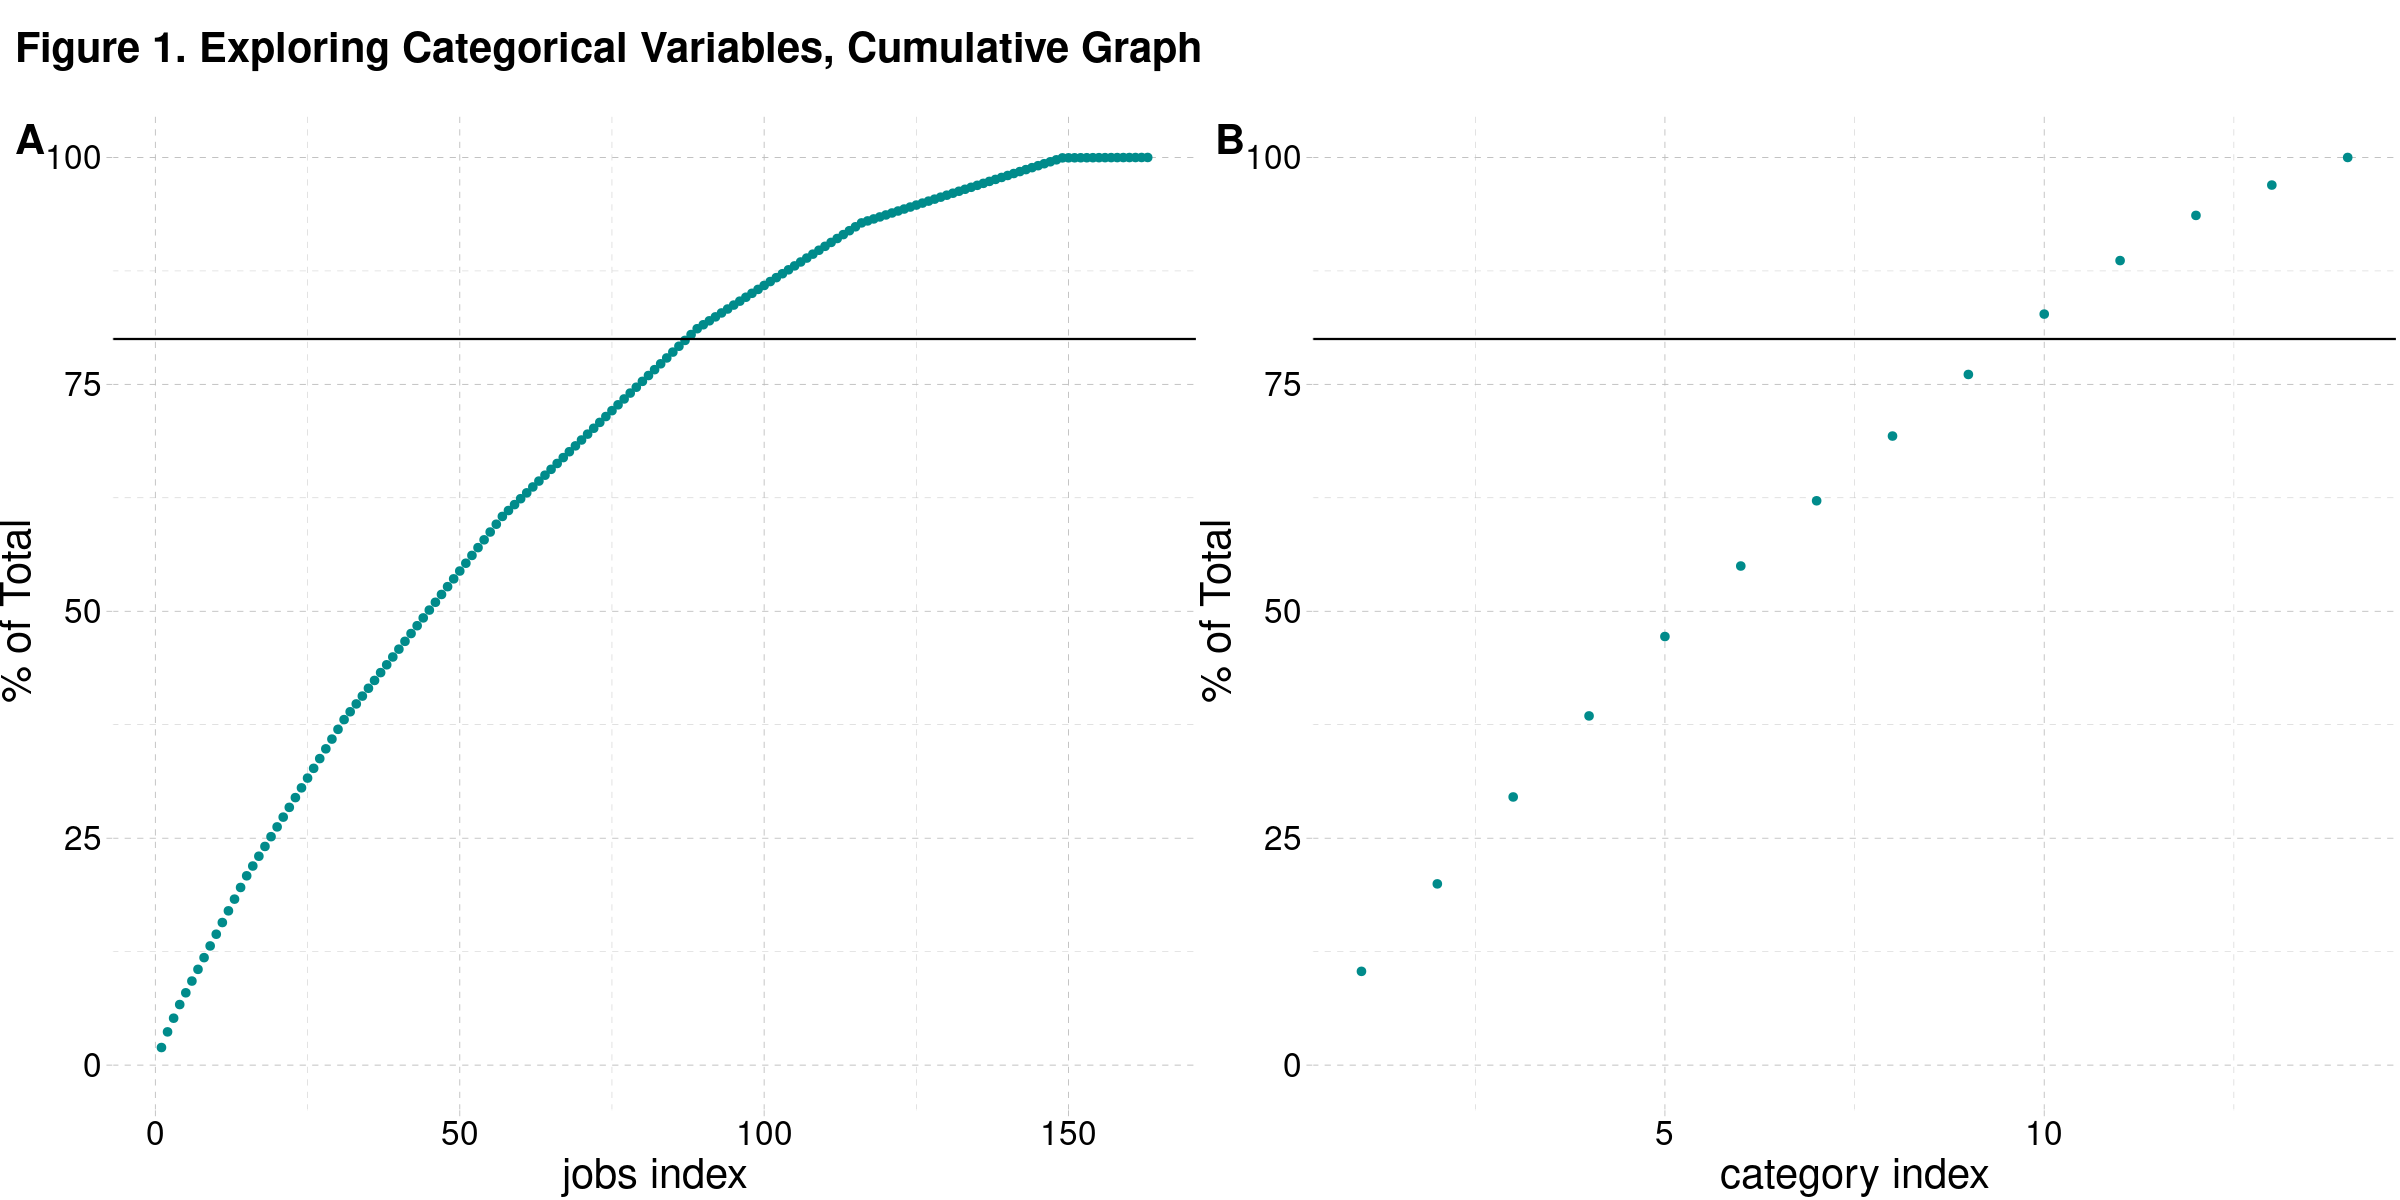

In [8]:
# Code Block 7: Exploring the Compactness of the Categories

# I use the gt package to create formatted tables.  The code I use below is not the standard 
# syntax, but apparently it is required for Jupyter and other notebooks at the current time. 
# This is a known issue:   https://github.com/rstudio/gt/issues/823


# For cumulative plots following:
# https://stackoverflow.com/questions/15844919/cumulative-plot- using-ggplot2


# I want to see how the  counts are distributed.  If, say, 80% of the records came from 10 classes, then we could collapse the remaining  levels into an "other" category.

# Exploring the jobs factor
table_3a_data <- fraud %>% count (job, sort = TRUE) # bin and count the data and return sorted

# I want to see how the jobs counts are distributed. 
# creating a table to go with this, but not displaying it
table_3a <- table_3a_data %>%
gt() %>%
tab_header(title = "Table 3A: Jobs of Card Holders") %>%
cols_label(job = "Jobs", n = "Count") %>%
opt_stylize(style = 1, color = "green", add_row_striping = TRUE)
#gt:::as.tags.gt_tbl(table_3a)  # this shows the table 

fig_1a <- ggplot(table_3a_data, aes(x=1:nlevels(fraud$job),
                                    y=(cumsum(n) *100/nrow(fraud)) )) +
									geom_point(color= "darkcyan") + 
									geom_hline(yintercept = 80) +  # this is my marker for 80% of the data
			xlab("jobs index") +
			ylab("% of Total") +
			ylim(0, 100) +
			#ggtitle("Jobs of Card Holder") +  #will set title in cowplot part, but use here if standalone
			theme_pander(base_size = 20) #setting this theme and size globally did broke my viz

# same as above, but just for the category variable
table_3b_data <- fraud %>% count (category, sort = TRUE) 
table_3b <- table_3b_data %>%
gt() %>%
tab_header(title = "Table 3B: Transaction Category in Credit Card Fraud") %>%
cols_label(category = "Category", n = "Count") %>%
opt_stylize(style = 1, color = "blue", add_row_striping = TRUE) #%>%
#gt:::as.tags.gt_tbl(table_3b)

fig_1b <- ggplot(table_3b_data, aes(x=1:nlevels(fraud$category), 
                                    y=(cumsum(n) *100/ nrow(fraud)) )) + 
			geom_point(color= "darkcyan") + 
			geom_hline(yintercept = 80) +
			xlab("category index") +
			ylab("% of Total") +
			ylim(0, 100) +
			#ggtitle("Figure 4: Jobs of Card Holder") +
			theme_pander(base_size = 20) 

#this makes the panel grid and labels it
plot_fig_1a<- plot_grid(fig_1a, fig_1b, labels =c('A', 'B'), label_size = 20) 

#This creates the figure title
title_1 <- ggdraw() + 
  draw_label(
    "Figure 1. Exploring Categorical Variables, Cumulative Graph",
    fontface = 'bold',
    x = 0,
    hjust = 0, 
    size = 20
  ) +
  theme(
    # add margin on the left of the drawing canvas,
    # so title is aligned with left edge of first plot
    plot.margin = margin(0, 0, 0, 7)
  )

#this combines the panel grid, title, and displays both
plot_grid(
  title_1, plot_fig_1a,
  ncol = 1,
  
  # rel_heights values control vertical title margins
  rel_heights = c(0.1, 1)
)


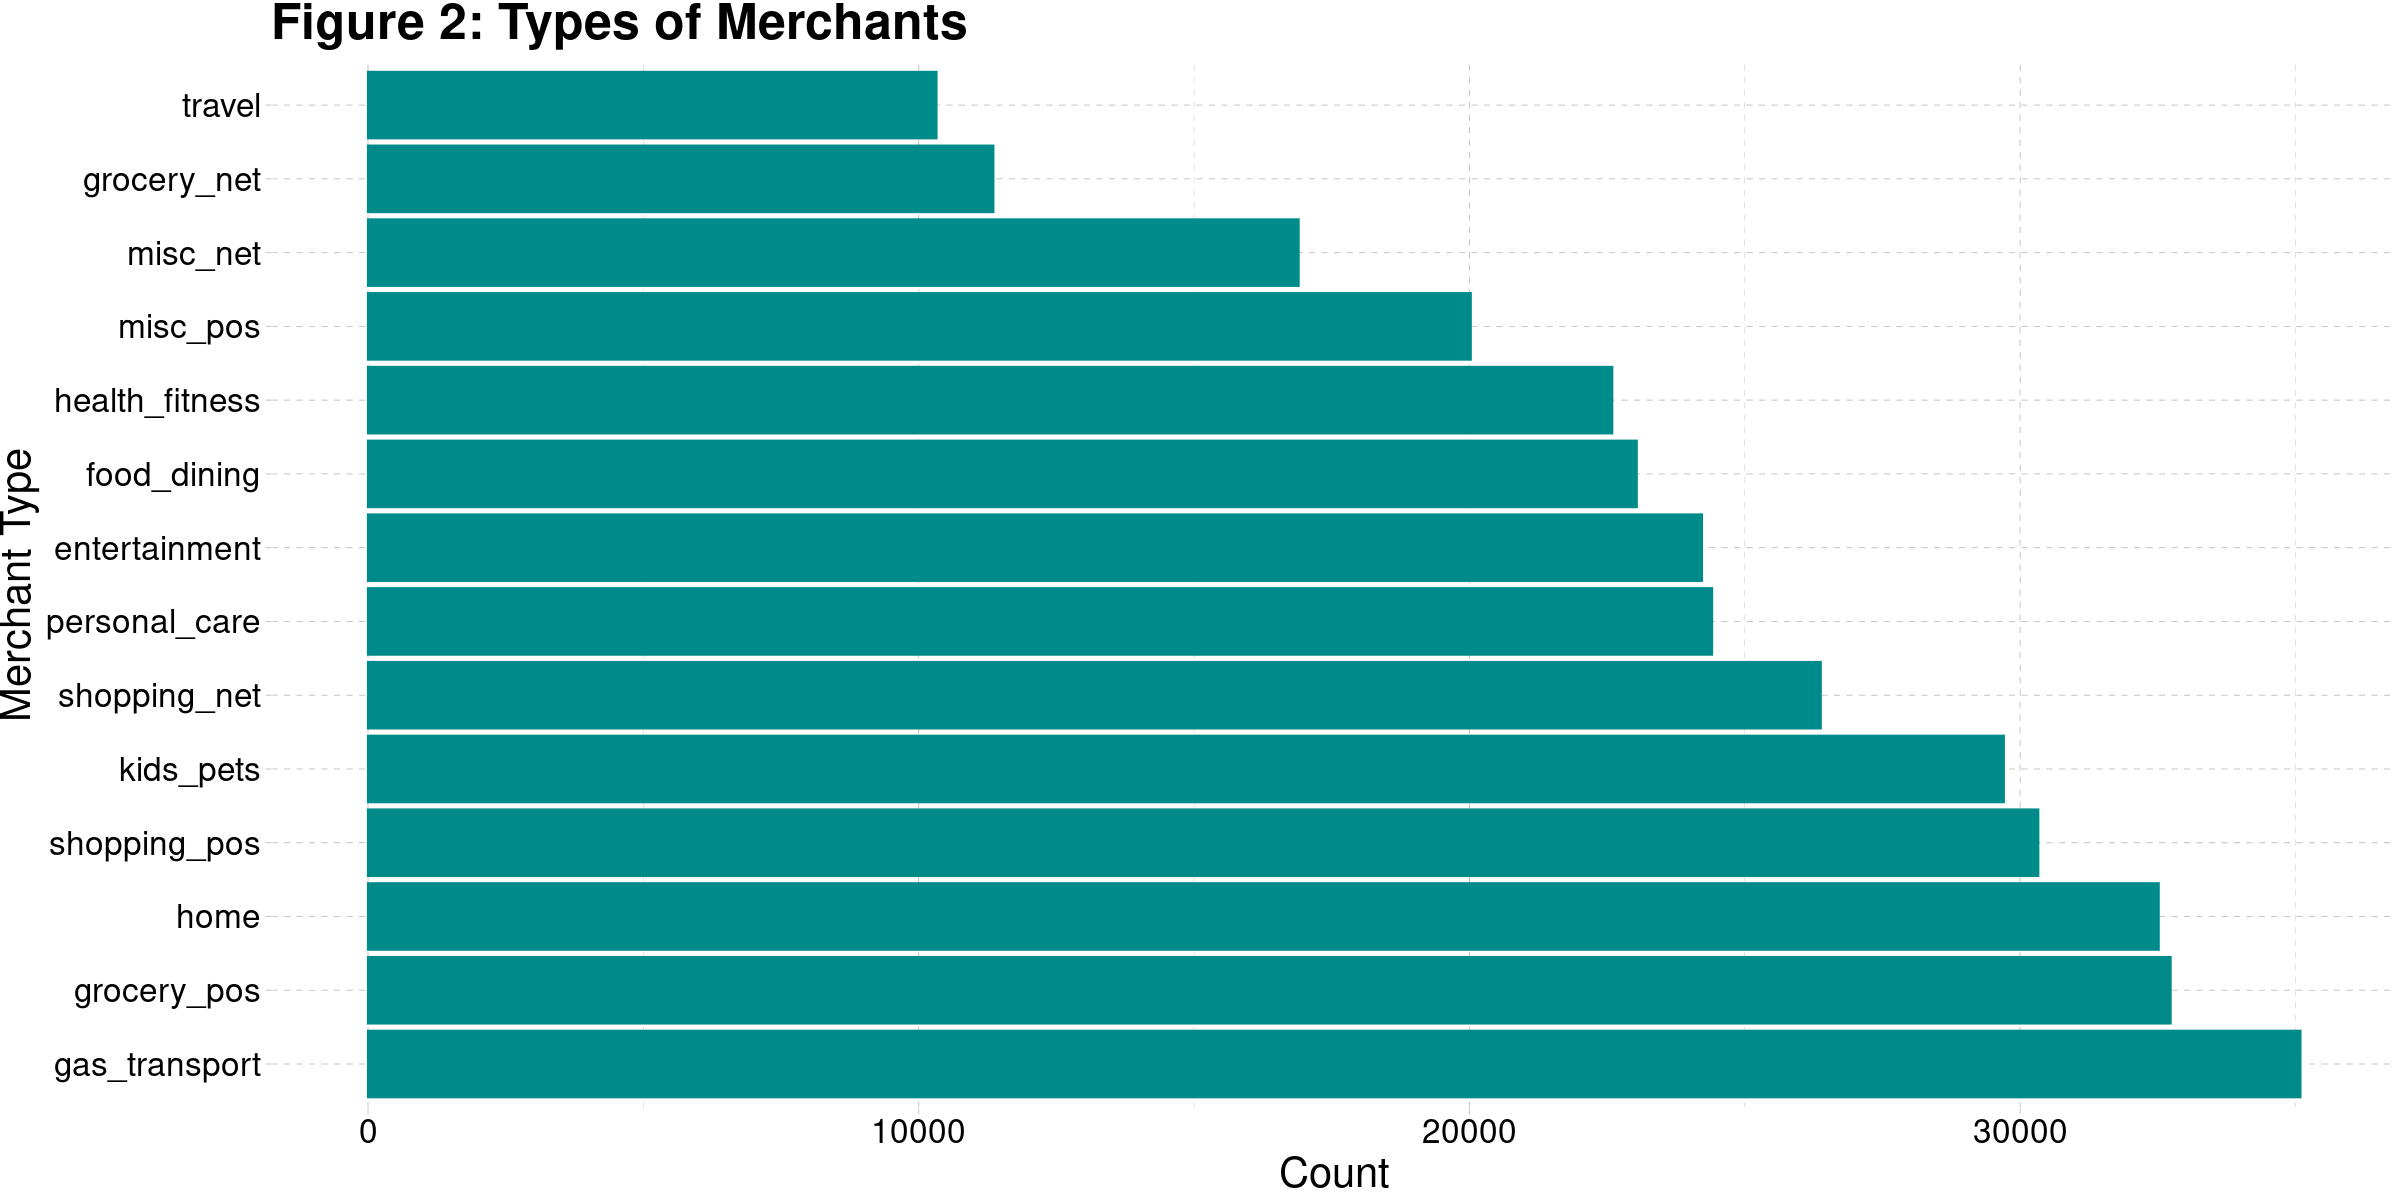

In [9]:
# Code Block 8: Exploring the Category factor
ggplot(fraud, aes(fct_infreq(category))) +
geom_bar(color= "darkcyan", fill = "darkcyan") +
ggtitle("Figure 2: Types of Merchants") +
coord_flip() + 
ylab("Count") +
xlab("Merchant Type") +
theme_pander(base_size = 20) 



## 4.1.2 Looking at our Character Strings
Merchant name (`merchant`) and transaction number(`trans_num`) are both strings. Transaction number should not influence fraud rate as it is a number assigned to the transaction when processed. I will drop it from our dataset. Merchant name could be correlated with fraud, for example, if a company's employee was involved. However, this data is also represented by the location and category. If a location/category is found to have higher levels of fraud, then a more detailed examination of those transactions can be performed, including the merchant name. Here, I remove it from the dataset (Code Block 9)

In [10]:
# Code Block 9: Removing Character/ String Variables
fraud <- fraud %>%
select(-merchant, -trans_num)

## 4.2 Looking at the geographic data
This data is coded as numeric (latitude and longitude) or character (city/state), but we can recognize it as geographic data and treat it appropriately.

First, there are two sets of geographic data related to the merchant. The location of the merchant and where the transaction occurred. These two sets of data are highly correlated (0.99) and thus are redundant (Code Block 10). So I remove `merch_lat` and `merch_long` from the dataset (Code Block 11).

There seem to be some locations where all transactions are fraudulent, Figure 4 (Code Block 12).

The `city` and `state` data is transformed to latitude and longitude in Code Block 13. I calculate the distance between the home location and the transaction location in Code Block 14-15. This new feature (`distances_miles`) is retained, and the original variables (`city`, `state`) and the intermediate variables (address, variabless used to calculate distance) are removed in Code Block 16.

[1] "Correlation between Merchant and Transaction Latitudes: "


[1] 0.9936461

[1] "Correlation between Merchant and Transaction Longitudes: "


[1] 0.9989605

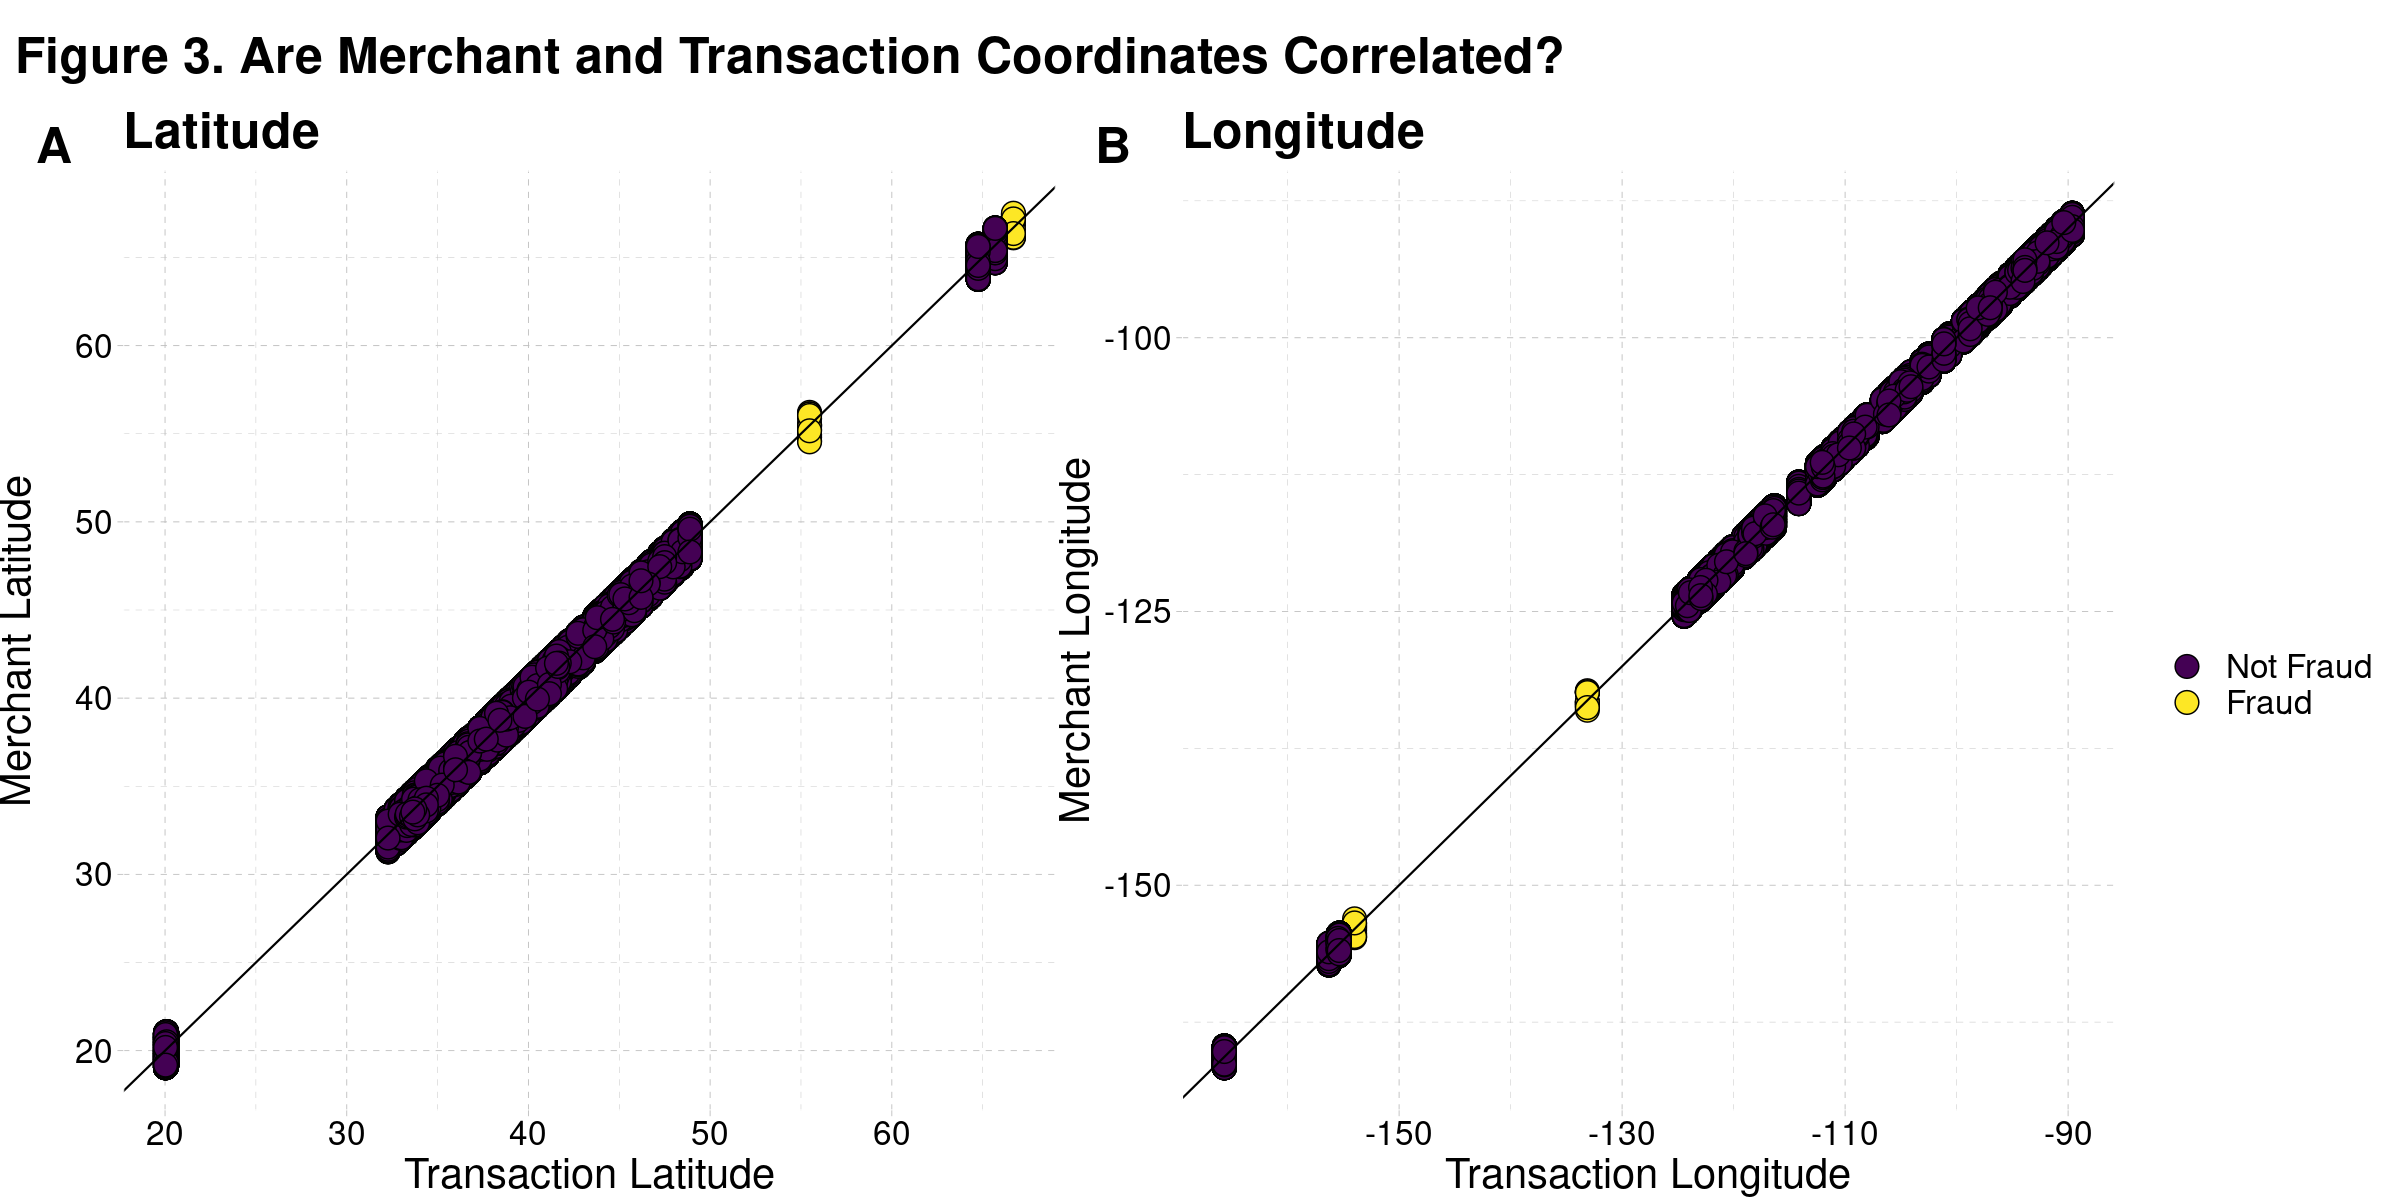

In [11]:
# Code Block 10: Comparing Merchant and Transaction Locations

print("Correlation between Merchant and Transaction Latitudes: ")
cor(fraud$lat, fraud$merch_lat)

print("Correlation between Merchant and Transaction Longitudes: ")
cor(fraud$long, fraud$merch_long)

#these figures take about 30-40 sec to generate
fig_3a <- ggplot(fraud, aes(lat, merch_lat, fill = factor(is_fraud)))+
geom_point(alpha = 1, shape = 21, colour = "black", size = 5 ) +
ggtitle("Latitude") +
ylab("Merchant Latitude") +
xlab("Transaction Latitude") +
scale_fill_viridis(discrete = TRUE, labels=c('Not Fraud', 'Fraud'), name="") +
geom_abline(slope=1, intercept=0) +
theme_pander(base_size = 20)

fig_3b <- ggplot(fraud, aes(long, merch_long, fill = factor(is_fraud)))+
geom_point(alpha = 1, shape = 21, colour = "black", size = 5 ) +
ggtitle("Longitude") +
ylab("Merchant Longitude") +
xlab("Transaction Longitude") +
scale_fill_viridis(discrete = TRUE, labels=c('Not Fraud', 'Fraud'), name="") +
geom_abline(slope=1, intercept=0) +
theme_pander(base_size = 20)

#shared legend from https://wilkelab.org/cowplot/articles/shared_legends.html
prow <- plot_grid(
  fig_3a + theme(legend.position="none"),
  fig_3b + theme(legend.position="none"),
   align = 'vh',
  labels = c("A", "B"),
  label_size = 24,
  hjust = -1,
  nrow = 1
)

legend <- get_legend(
  # create some space to the left of the legend
  fig_3a + theme(legend.box.margin = margin(0, 0, 0, 12))
)

# add the legend to the row we made earlier. Give it one-third of 
# the width of one plot (via rel_widths).
plot_fig_3 <- plot_grid(prow, legend, rel_widths = c(3, .4))

title_3 <- ggdraw() + 
  draw_label(
    "Figure 3. Are Merchant and Transaction Coordinates Correlated?",
    fontface = 'bold',
    size = 24,
    x = 0,
    hjust = 0
  ) +
  theme(
    # add margin on the left of the drawing canvas,
    # so title is aligned with left edge of first plot
    plot.margin = margin(0, 0, 0, 7)
  )

plot_grid(
  title_3, plot_fig_3,
  ncol = 1,
  # rel_heights values control vertical title margins
  rel_heights = c(0.1, 1)
)


In [12]:
# Code Block 11: Removing merch_lat and merch_long
fraud <- fraud %>%
select( -merch_lat, -merch_long) %>%
rename(lat_trans = lat, long_trans = long)

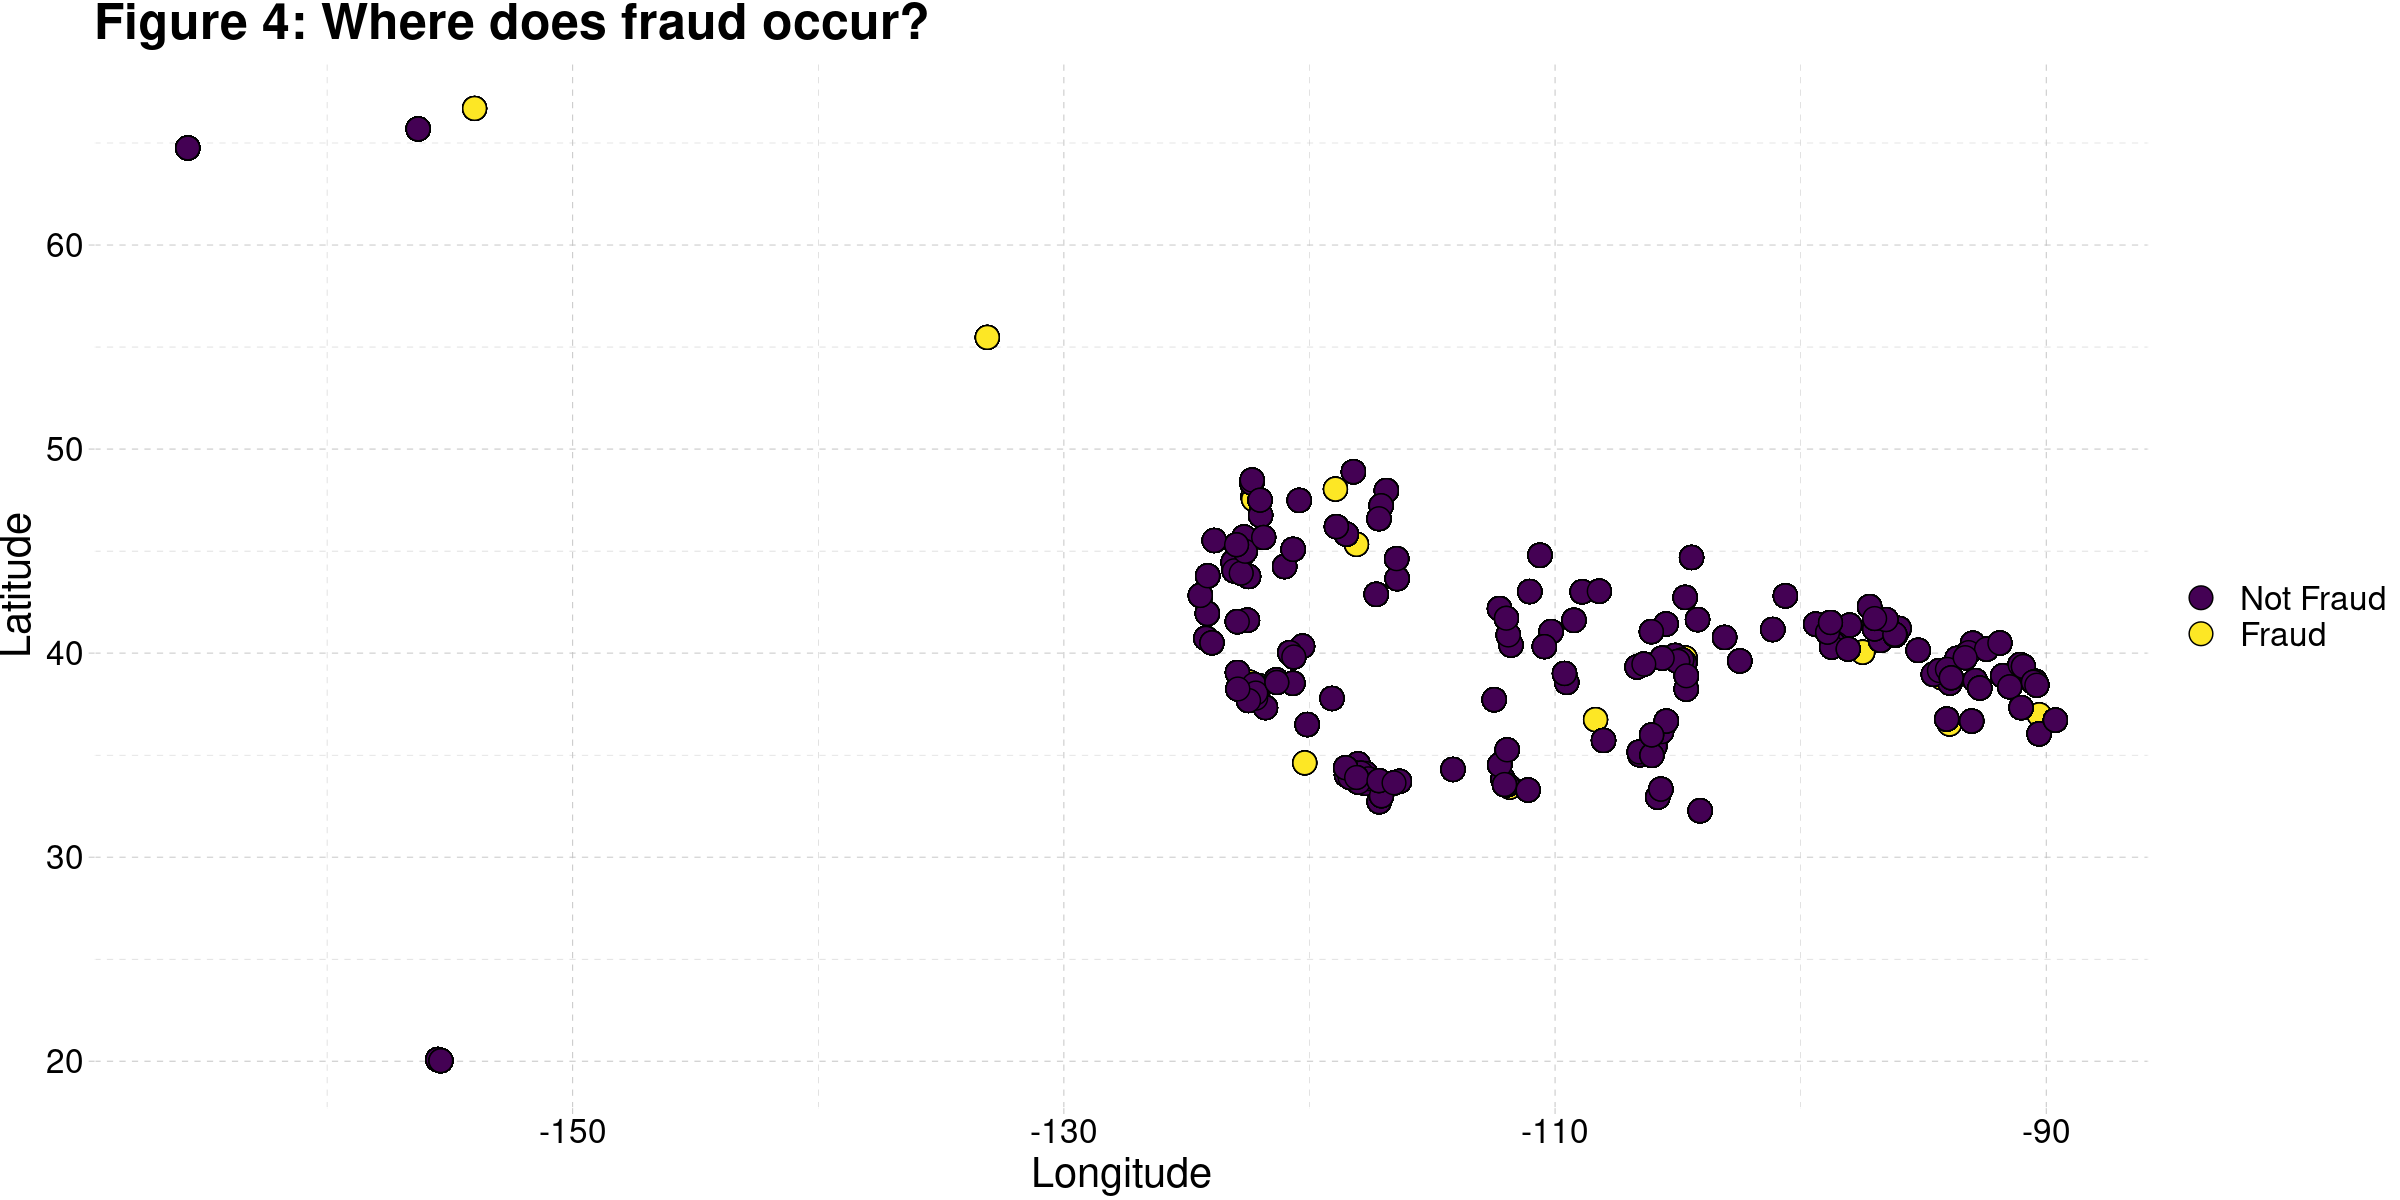

In [13]:
# Code Block 12: Looking at Fraud by Location
ggplot(fraud, aes(long_trans, lat_trans, fill = factor(is_fraud)))+
geom_point(alpha = 1, shape = 21, colour = "black", size = 5, position = "jitter") +
scale_fill_viridis(discrete = TRUE, labels=c('Not Fraud', 'Fraud'), name="") +   
ggtitle("Figure 4: Where does fraud occur? ") +
ylab("Latitude") +
xlab("Longitude") +
theme_pander(base_size = 20)

In [14]:
# Code Block 13: Converting city/state data lat/long

# need to pass an address to geo to convert to lat/long
fraud <- fraud %>%
mutate(address = str_c(city, state, sep = " , "))

# generate a list of distinct addresses to look up
# the dataset is large, so it is better to only look up unique address rather that the address
# for every record
address_list <- fraud %>%
distinct(address)

# this has one more than number in the cities, so there must be a city with the same name in more than one state.

#I don't want to run this api call everytime I open the notebook, so I downloaded the data and will reimport it and load it 
# Below is the code to run the call.  Uncomment it.
# gets coordinates for city,states
# https://stackoverflow.com/questions/68671631/getting-latitude-and-longitude-in-r-with-only-city-state
# https://jessecambon.github.io/tidygeocoder/
# https://jessecambon.github.io/tidygeocoder/reference/geo.html
# home_coords <-  geo(address_list$address, method = "osm", full_results = FALSE) 
# I downloaded it using the gui interface provided by datacamp when you view the object.


# Reimport the data eimport it and load it 
home_coords <- read_csv('downloaded_coords.csv', show_col_types = FALSE)


# imported home coords has an extra set of quotation marks
home_coords<- home_coords %>%
mutate(address = str_replace_all(address, "\"", "")) %>%
rename(lat_home = lat, long_home = long)

# use a left join on fraud and home_coords to assign the coord to every address in fraud
fraud <- fraud %>%
left_join(home_coords, by = "address")


In [15]:
# Code Block 14: Distance Between Home and Transaction

# following : https://www.geeksforgeeks.org/program-distance-two-points-earth/amp/
# I believe this assuming a spherical Earth

# convert to radians
fraud <- fraud %>%
mutate(lat1_radians = lat_home/57.29577951, lat2_radians =lat_trans/57.29577951,
       long1_radians= long_home/57.29577951, long2_radians= long_trans/57.29577951)

# calculating distance
fraud <- fraud %>% mutate (distance_miles = 3963.0 * acos((sin(lat1_radians) 
                                                          * sin(lat2_radians))+ cos(lat1_radians)
                                                          * cos(lat2_radians) * 
                                                          cos(long2_radians - long1_radians)))



print("Correlation between Distance and Fraud: ")
cor(fraud$distance_miles, fraud$is_fraud)

[1] "Correlation between Distance and Fraud: "


[1] -0.002728084

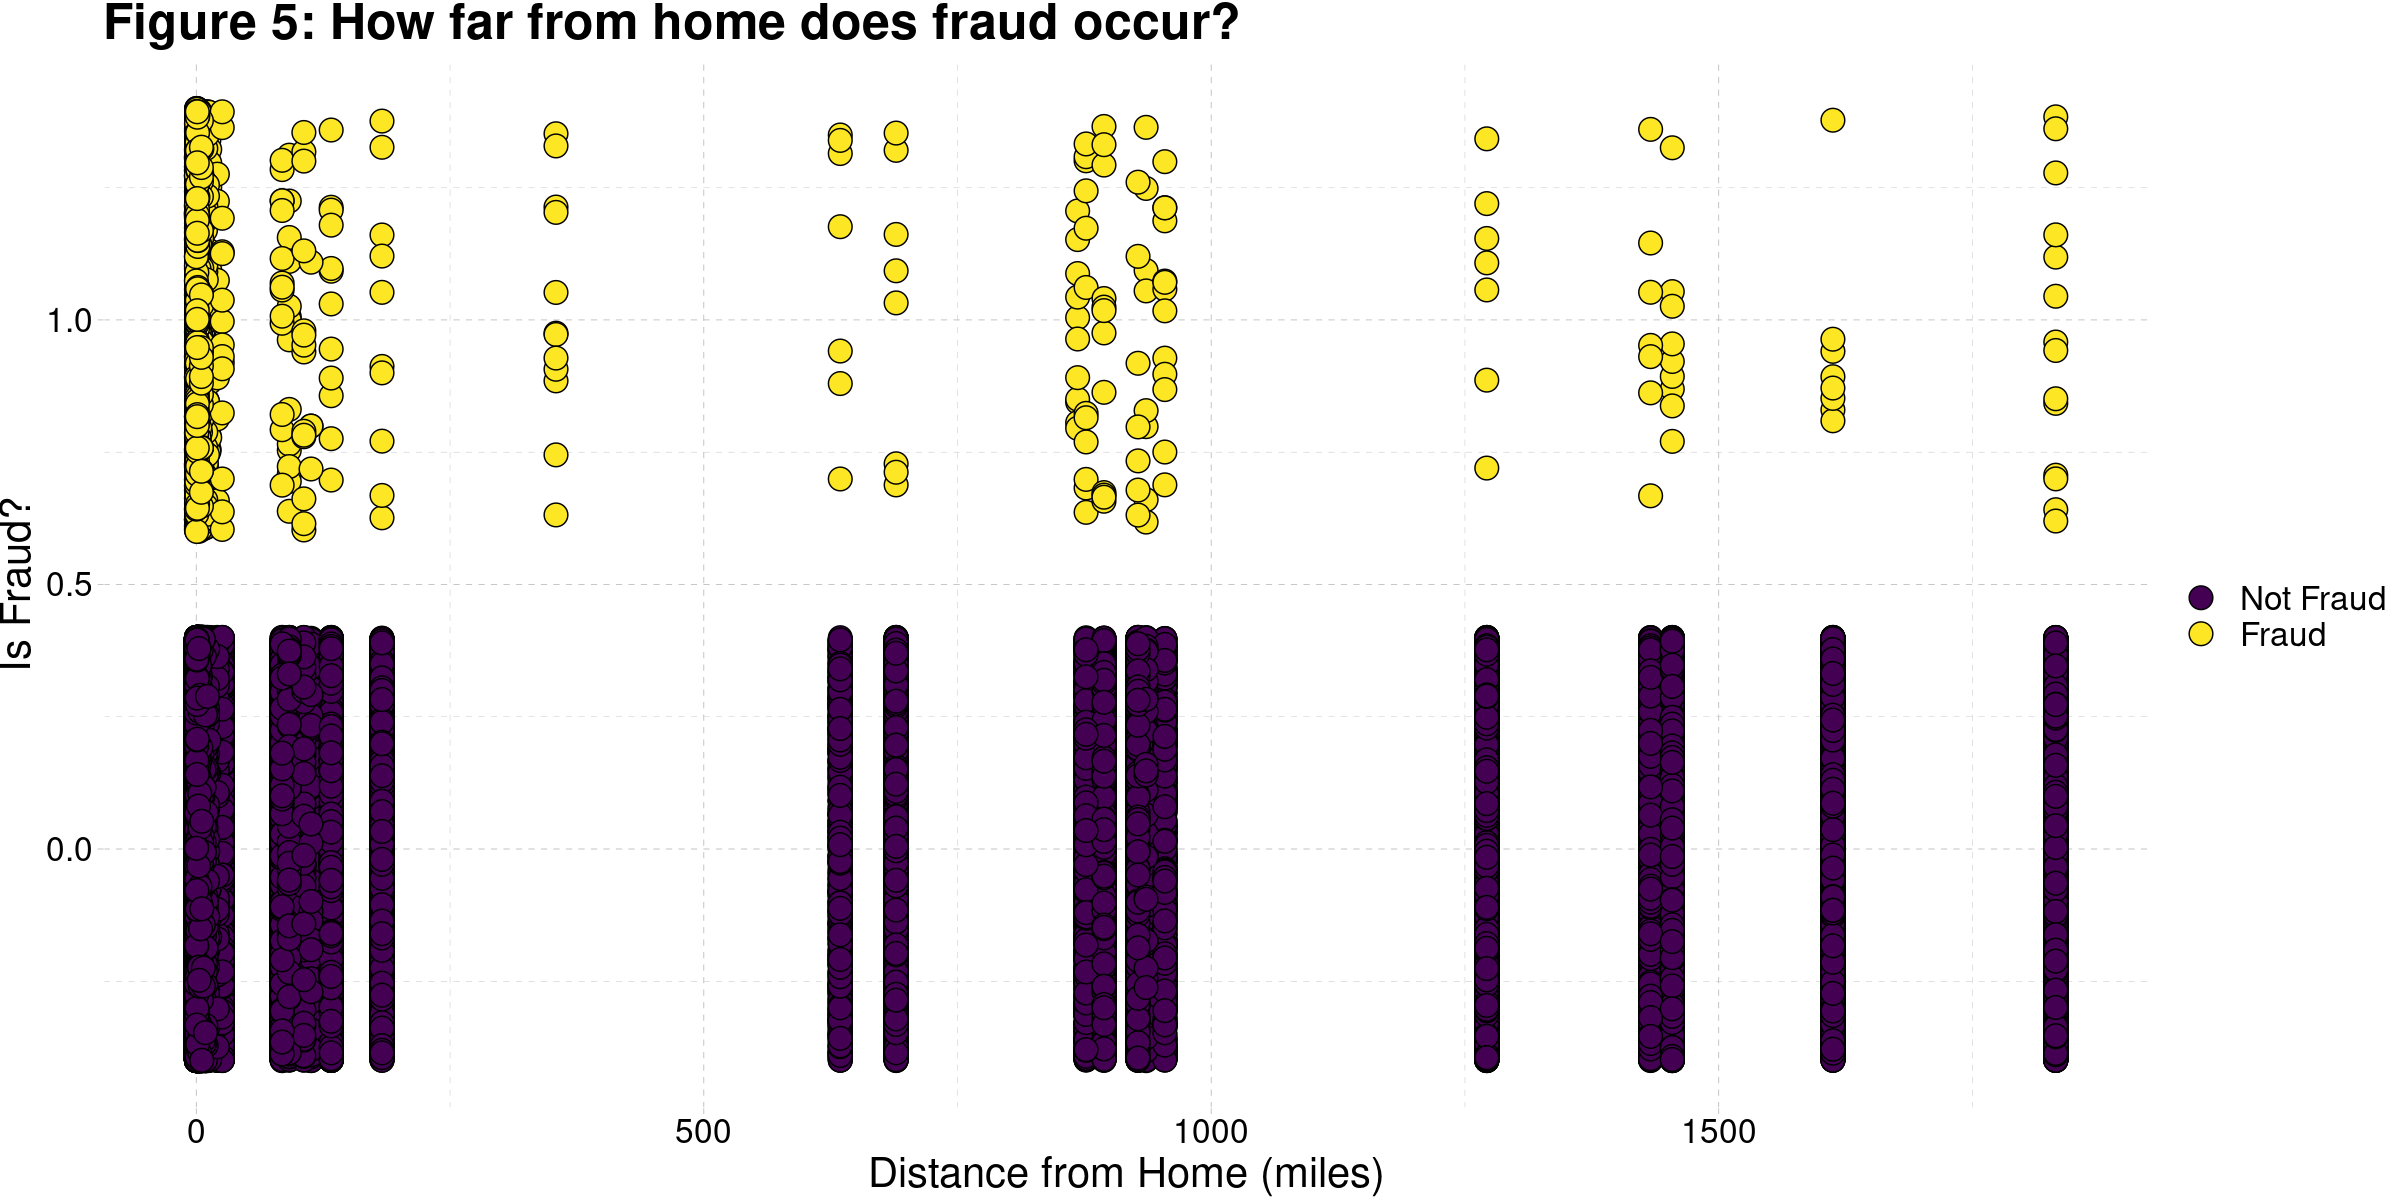

In [16]:
# Code Block 15: Distance from Home and Fraud
ggplot(fraud, aes(distance_miles, is_fraud , fill = factor(is_fraud))) +
#ggplot(fraud, aes(distance_miles, is_fraud, fill = factor(is_fraud))) +
geom_point(alpha = 1, shape = 21, colour = "black", size = 5, position = "jitter") +
#geom_col() +
scale_fill_viridis(discrete = TRUE, labels=c('Not Fraud', 'Fraud'), name="") +   
ggtitle("Figure 5: How far from home does fraud occur?") +
xlab("Distance from Home (miles)") +
ylab("Is Fraud?") +
theme_pander(base_size = 20)




In [17]:
# Code Block 16: Remove Extraneous/Temp Variables

# created to calculate distance
fraud <- fraud %>%
select(-lat1_radians, - lat2_radians, -long1_radians, -long2_radians )

#remove city and state and address, replaced by lat/long
fraud <- fraud %>%
select(-city, - state, -address )

## 4.3 Looking at our Dates
**Date**

dob,						Date of Birth of Credit Card Holder

Questions:
- What is the date range, and does it make sense?
- Do we have improbably old or young people?
- Do we have ahistoric or futuristic transaction dates?

I calculate the age from the `dob`, and both are visualized in Code Block 17. 

Conclusions:
The ages seem reasonable (calculated relative to the earliest date of transactions). There are a few thousand 17-year-olds, which is too young to have their own credit card, but it is plausible that they would be an authorized user on their parents' card. `age` seems a more reasonable variable than `dob`, so `dob` is also dropped from the dataset (Code Block 18). For example, scammers might be more likely to target 90-year-olds. The age is the feature that leads to them being targeted, not the birth year. The birth year is related to age through the current date- in 10 years, a new cohort of birth years would be targeted if age is the important feature. So the age feature is more robust to passing time than dob.


Min.      1st Qu.       Median         Mean      3rd Qu.         Max. 
"1927-09-09" "1961-10-24" "1974-03-10" "1972-04-03" "1985-08-21" "2001-07-26"

Shiny tags cannot be represented in plain text (need html)

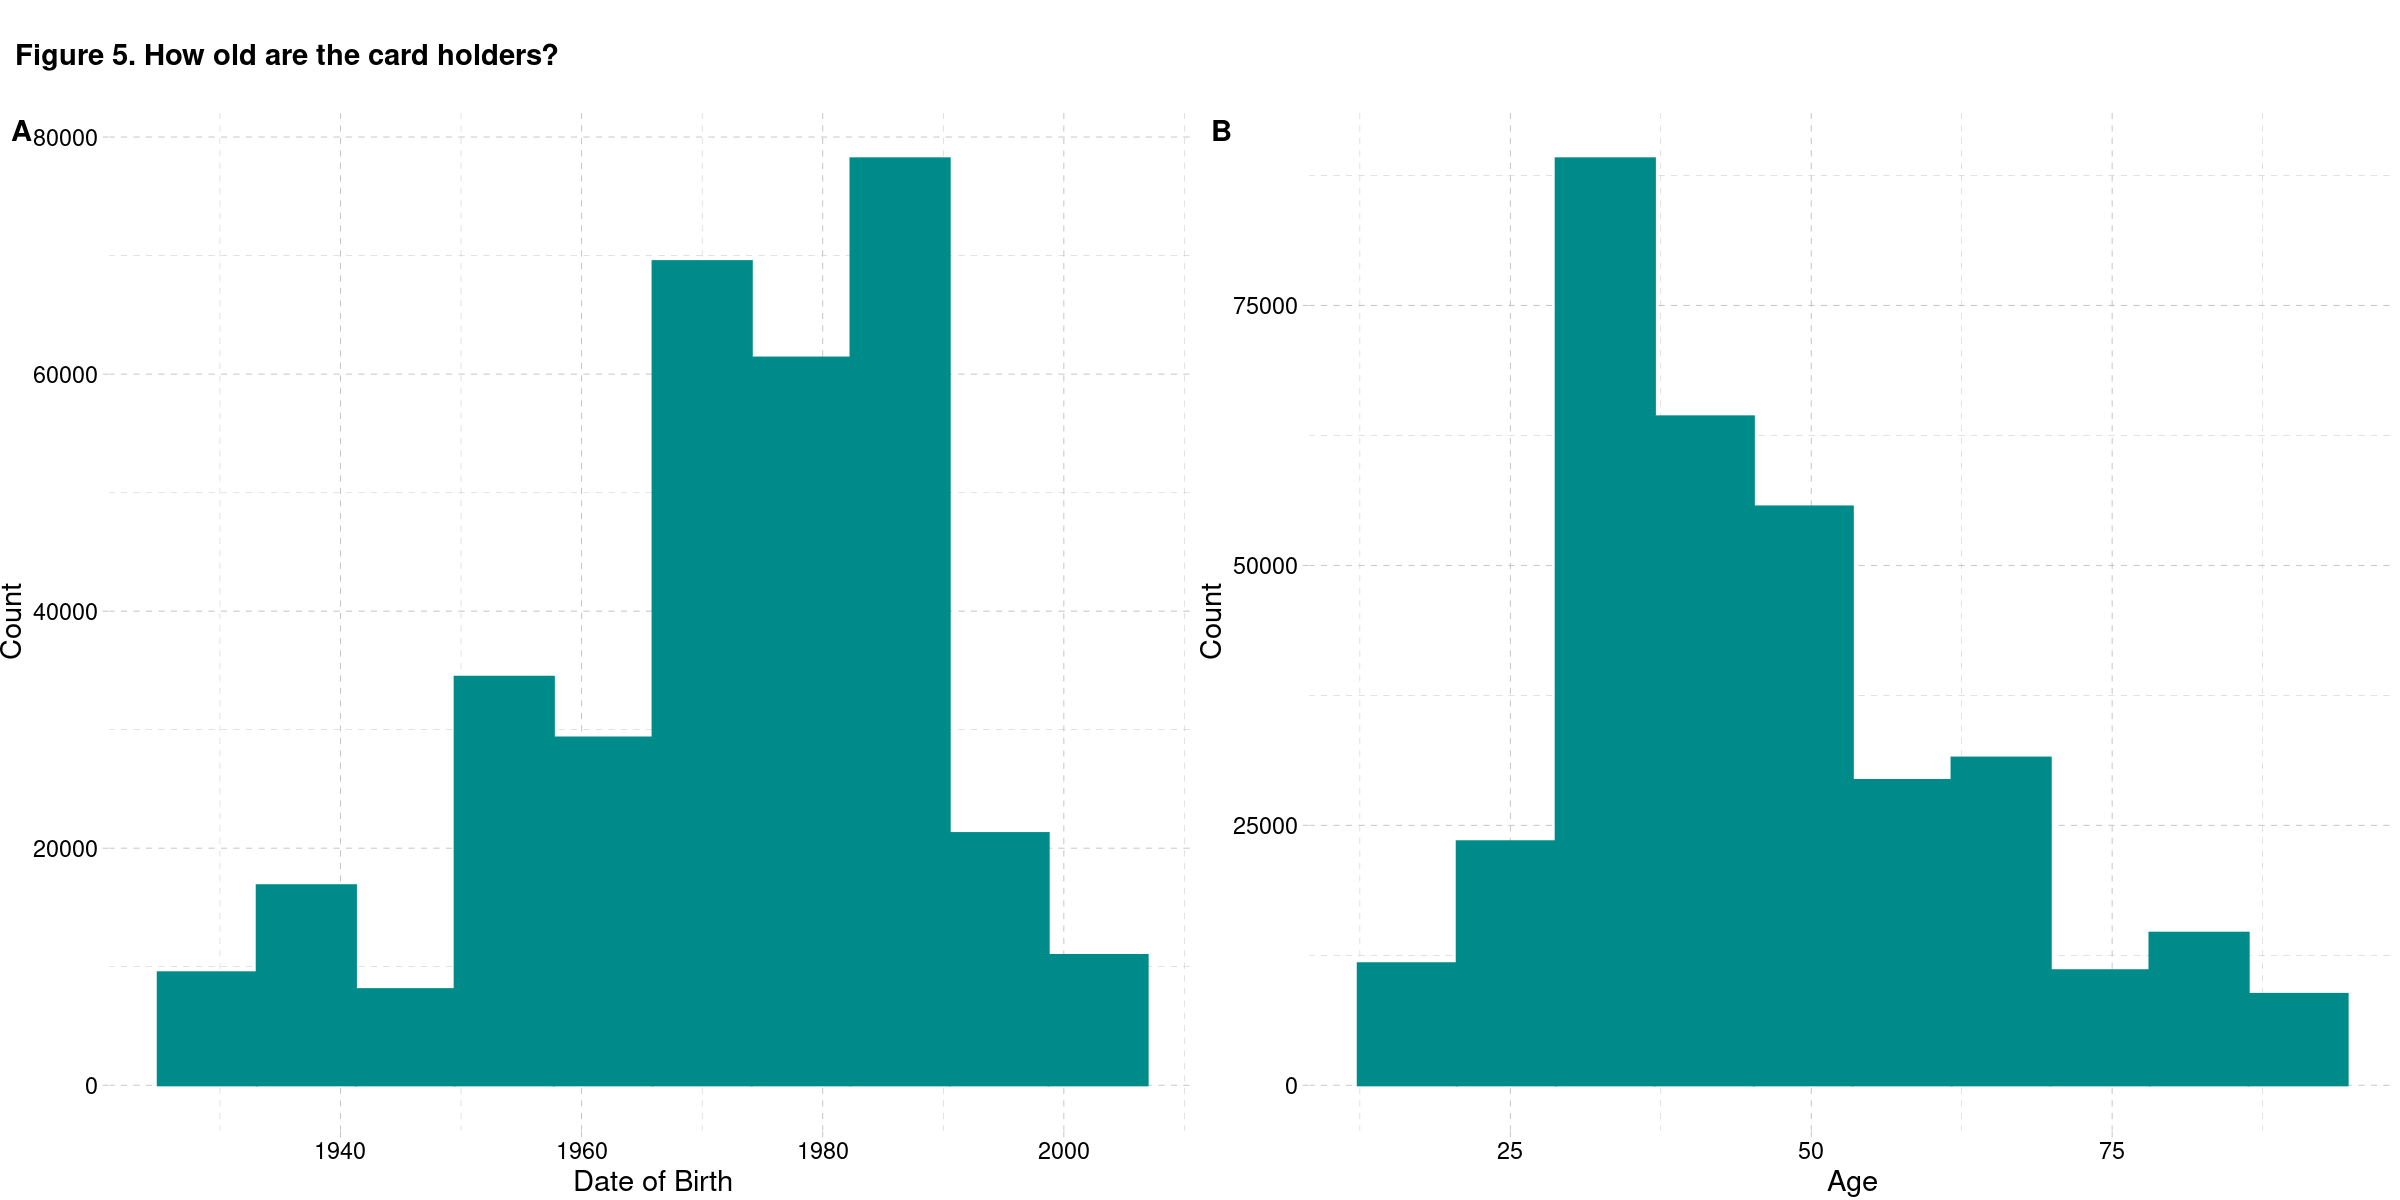

In [18]:
# # Code Block 17: Looking at dob

summary(fraud$dob)

fig_5a <- ggplot(fraud, aes(dob))+
geom_histogram(color= "darkcyan", fill = "darkcyan" , bins = 10) +
#ggtitle("Figure 5: How old are card Holders?") +
ylab("Count") +
xlab("Date of Birth") +
theme_pander(base_size = 14)


fraud <- fraud %>%
#mutate (age = trunc((dob %--% today()) / years(1))) #if you wanted to calculate age relative to today
mutate (age = trunc((dob %--% min(fraud$trans_date_trans_time)) / years(1)))
#summary(fraud$age) #if you wanted a printed summary stats 


fig_5b <- ggplot(fraud, aes(age))+
geom_histogram(color= "darkcyan", fill = "darkcyan",  bins = 10) +
#ggtitle("Figure 6: How old are card Holders?") +
ylab("Count") +
xlab("Age") +
theme_pander(base_size = 14)

plot_fig5 <- plot_grid(fig_5a, fig_5b, labels =c('A', 'B')) 

title5 <- ggdraw() + 
  draw_label(
    "Figure 5. How old are the card holders?",
    fontface = 'bold',
    x = 0,
    hjust = 0
  ) +
  theme(
    # add margin on the left of the drawing canvas,
    # so title is aligned with left edge of first plot
    plot.margin = margin(0, 0, 0, 7)
  )
plot_grid(
  title5, plot_fig5,
  ncol = 1,
  # rel_heights values control vertical title margins
  rel_heights = c(0.1, 1)
)

table_3_data <- fraud %>% count (age) 

table_3 <- table_3_data %>%
gt() %>%
tab_header(title = "Table 3: Ages of Card Holders") %>%
cols_label(age = "Ages", n = "Count") %>%
opt_stylize(style = 1, color = "green", add_row_striping = TRUE)
gt:::as.tags.gt_tbl(table_3)


In [19]:
# Code Block 18: Removing dob

fraud <- fraud %>%
select(-dob)

## 4.3 Looking at our Date/Times
**Date/Time**

trans_date_trans_time	Transaction DateTime

**Questions**

Would processing the dates yield useful predictors?

I converted the date-times into date, hour, and day of the week, Code Block 20. I thought these might be more useful predictors than the composite date-time.
	
There is some variation in the number of transactions with date-time, see Code Block 19, Figure 6. Code Block 19 shows the number of transactions per day. Monday has the highest number of transactions; this could be due to businesses processing orders that came in over the weekend. Code Block 22 explores the time of day transactions occur. This data honestly looks funny to me. I might expect that most transactions would occur during normal business hours (~9-5) or more occur during lunch or after work, but what we see is a lower number of transactions from midnight to ~ 2 pm and then a higher number of transactions from 2 pm until midnight. The odd pattern could be a sign that something is wrong with the data (perhaps timezones aren't being encoded properly?), or it could be simply a lack of subject matter knowledge (for example, transactions are pre-authorized at the time of sale and processed later, and the transaction time is the processing time, not the sale time.)  Of course, this is also a synthetic dataset, so this pattern may be simply the result of user input choices when the set was generated. If this were a real dataset, I'd chase this down.

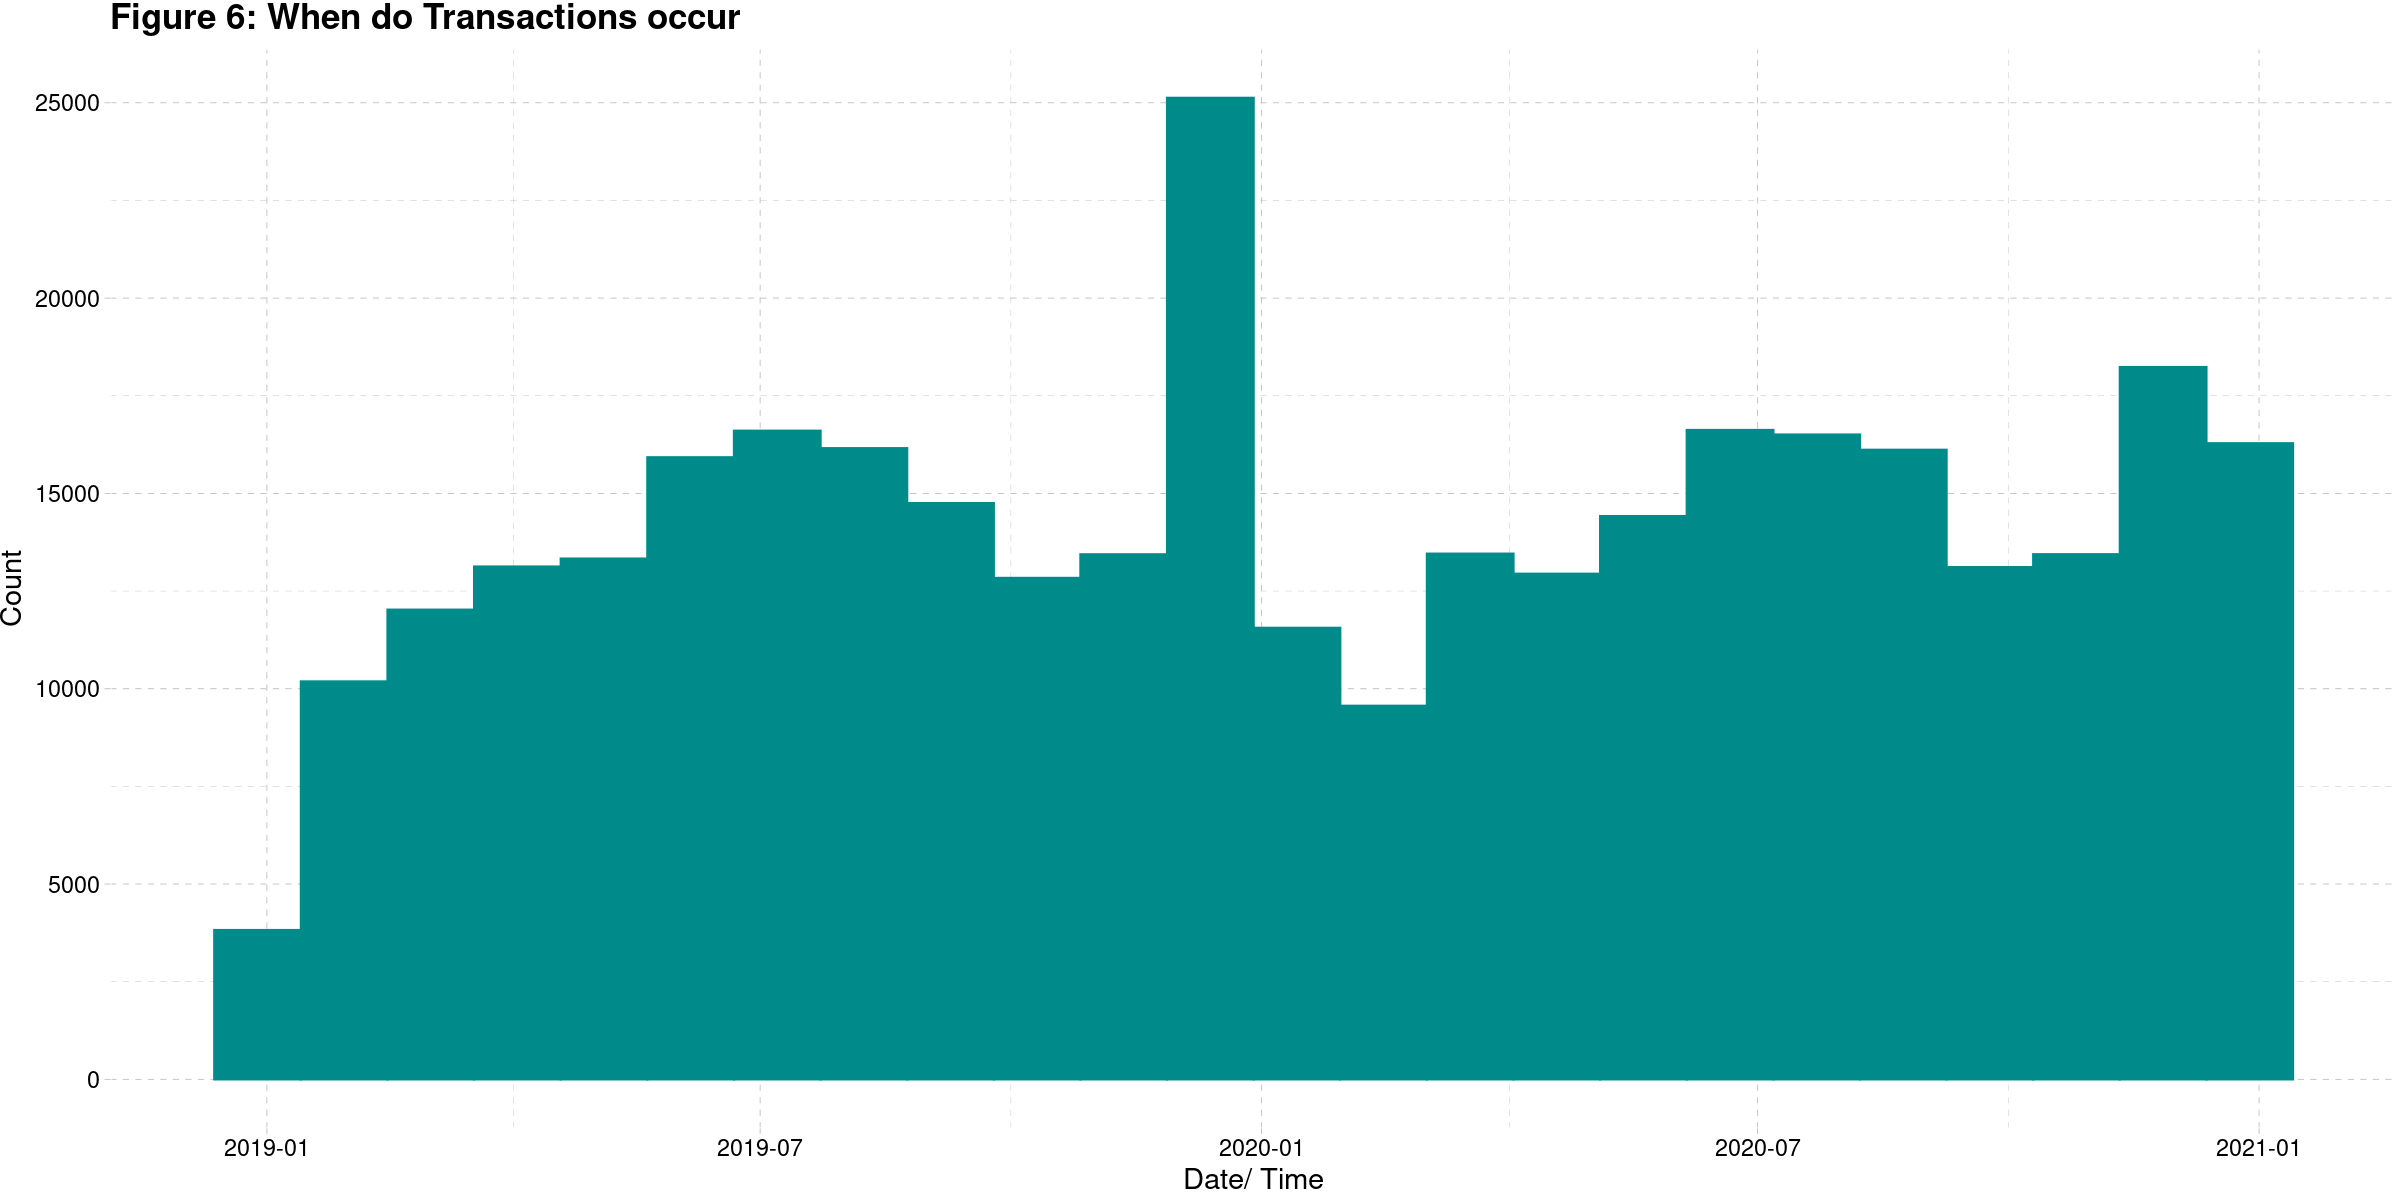

In [20]:
# Code Block 19: Looking at Transaction Date/ Times

ggplot(fraud, aes(trans_date_trans_time))+
geom_histogram(color= "darkcyan", fill = "darkcyan", bins = 24) +
ggtitle("Figure 6: When do Transactions occur") +
ylab("Count") +
xlab("Date/ Time") +
theme_pander(base_size = 14) #+


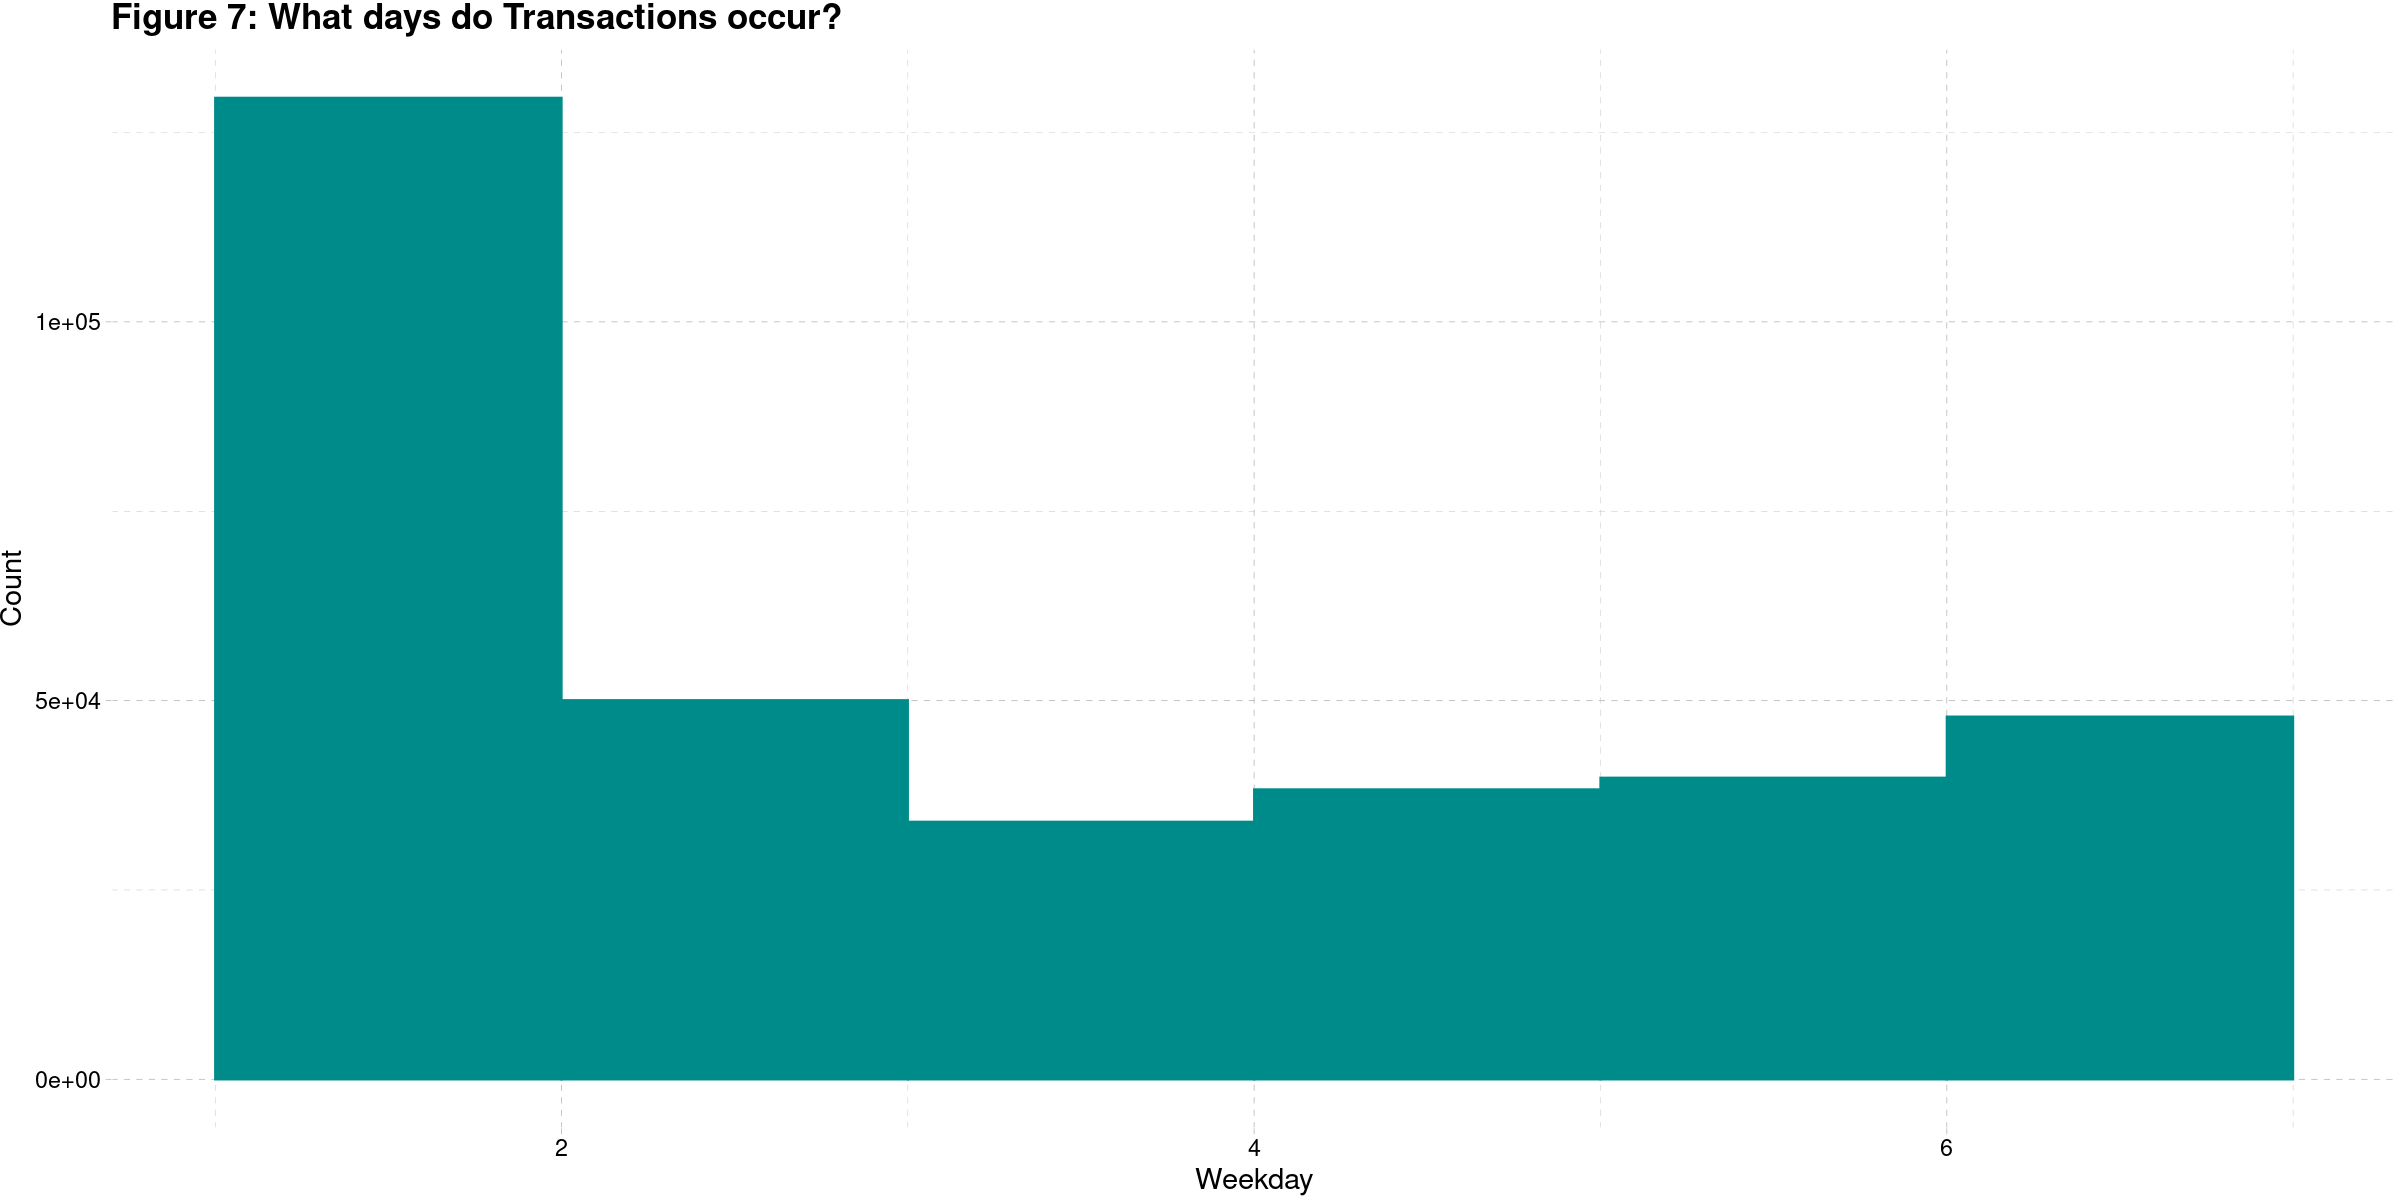

In [21]:
# Code Block 20: 

fraud <- fraud %>%
mutate (date_only = date(trans_date_trans_time), 
        hour = hour(trans_date_trans_time), 
        weekday = wday(trans_date_trans_time))

#week_start
#day on which week starts following ISO conventions - 1 means Monday, 7 means Sunday (default). When label = TRUE, this will be the #first level of the returned factor. You can set lubridate.week.start option to control this parameter globally.

ggplot(fraud, aes(weekday))+
geom_histogram(color= "darkcyan", fill = "darkcyan", binwidth = 1, center = 0.5) +
ggtitle("Figure 7: What days do Transactions occur?") +
ylab("Count") +
xlab("Weekday") +
theme_pander(base_size = 14) #+


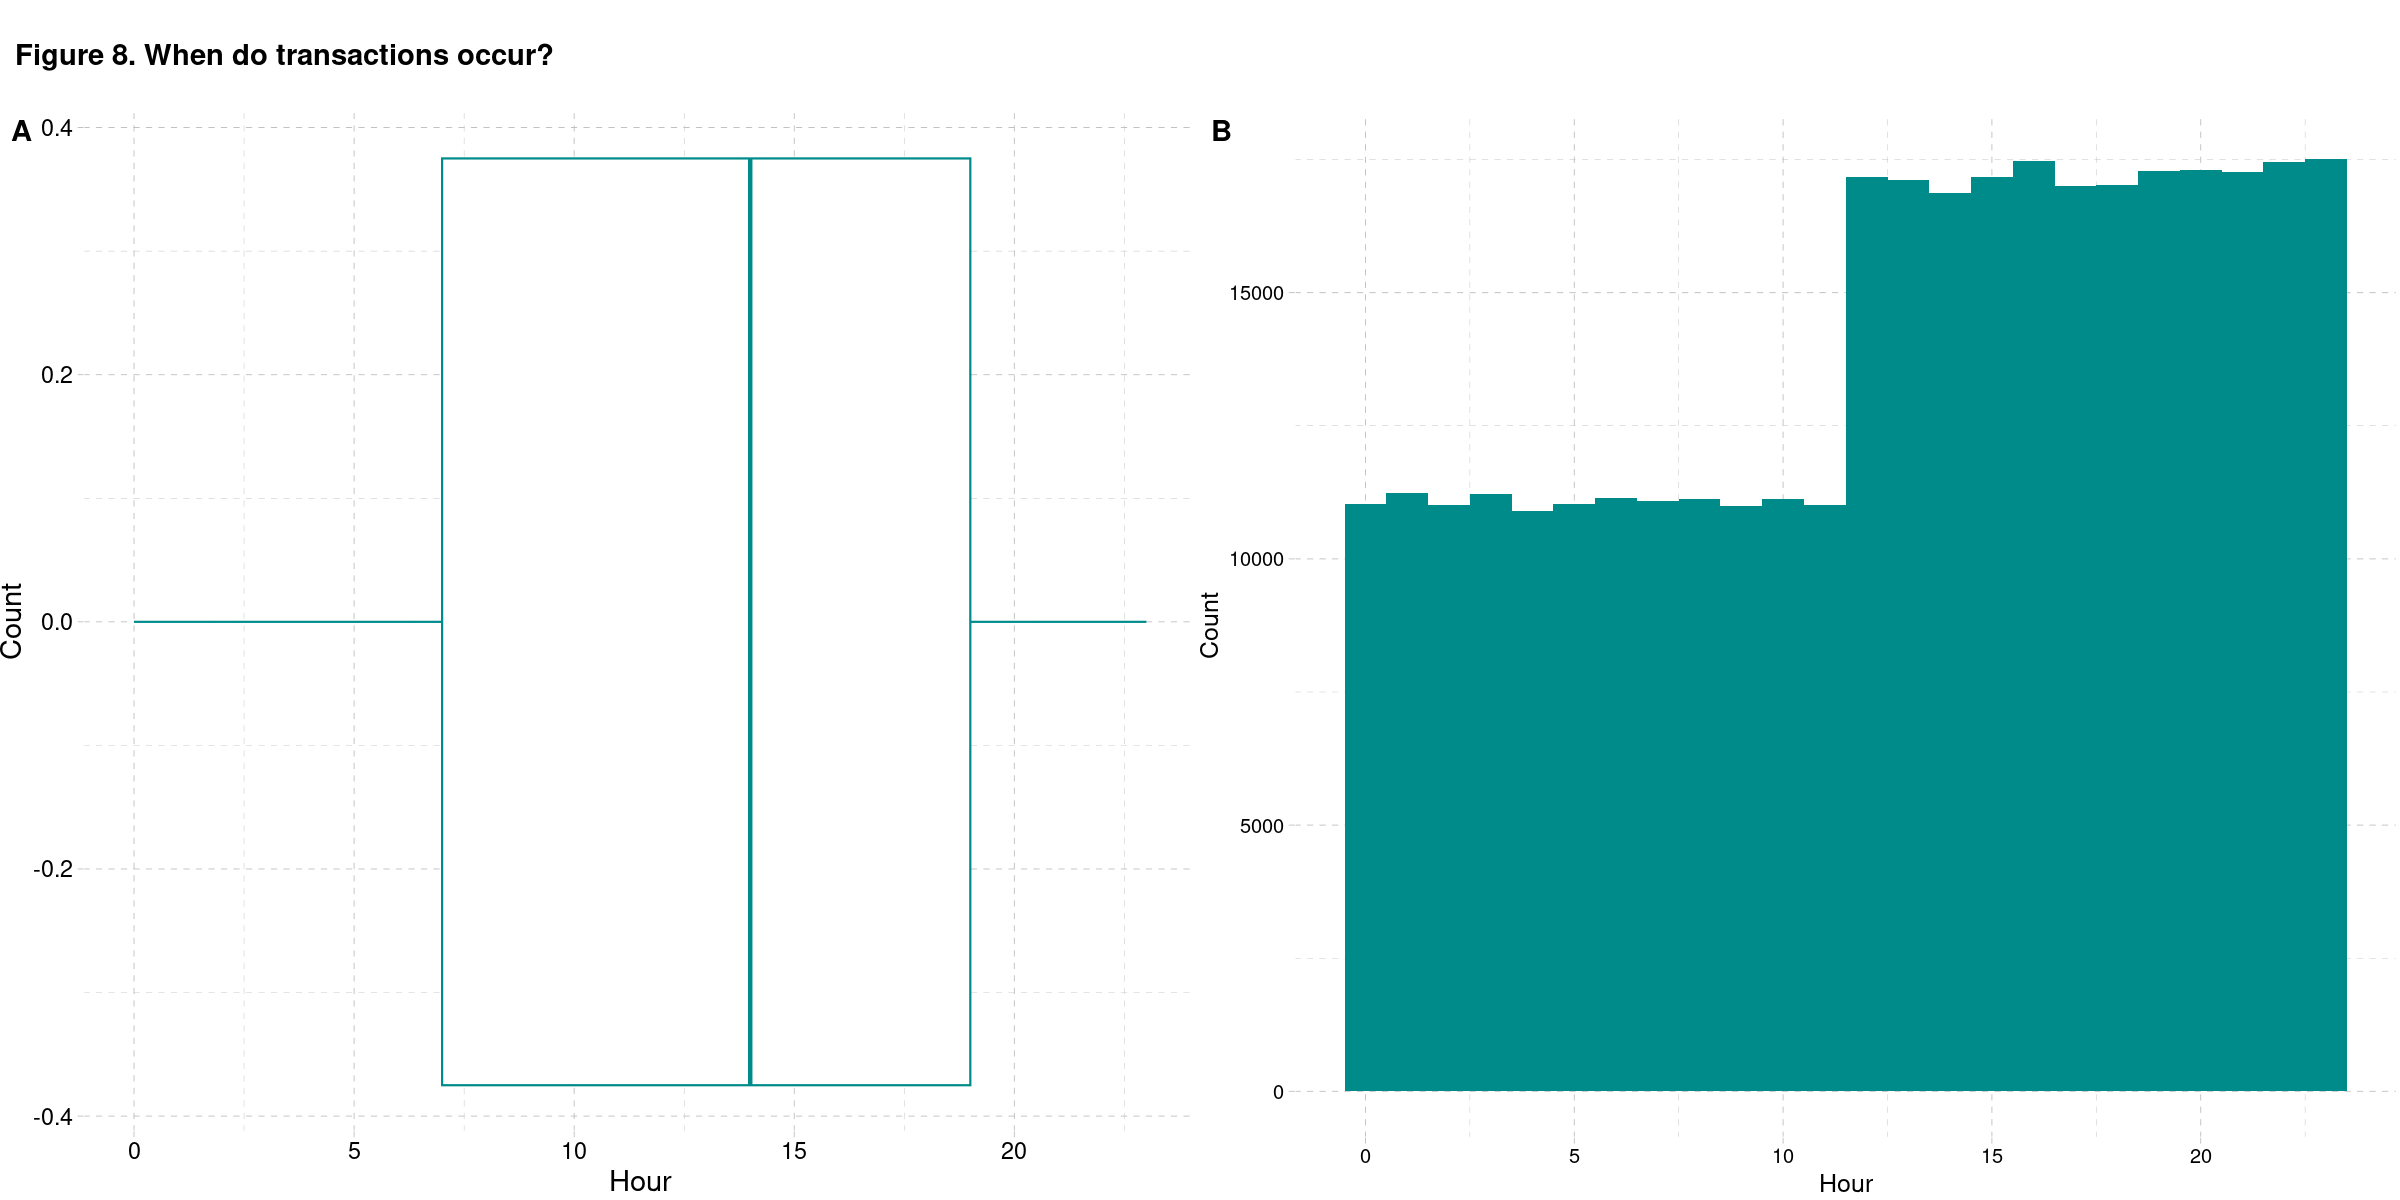

In [22]:
# Code Block 21: 
fig_8a <- ggplot(fraud, aes(hour))+
geom_boxplot(color= "darkcyan") +
#ggtitle("Figure 5: What HOUR Transactions occur") +
ylab("Count") +
xlab("Hour") +
theme_pander(base_size = 14) #+


#this histogram is weird and I think it in part, because it is a histogram and not a column chart
fig_8b <- ggplot(fraud, aes(hour))+
geom_histogram(fill= "darkcyan", bins = 24) +
#ggtitle("Figure 5: What HOUR Transactions occur") +
ylab("Count") +
xlab("Hour") +
theme_pander(base_size = 12)

plot_fig8 <- plot_grid(fig_8a, fig_8b, labels =c('A', 'B')) 

title8 <- ggdraw() + 
  draw_label(
    "Figure 8. When do transactions occur?",
    fontface = 'bold',
    x = 0,
    hjust = 0
  ) +
  theme(
    # add margin on the left of the drawing canvas,
    # so title is aligned with left edge of first plot
    plot.margin = margin(0, 0, 0, 7)
  )
plot_grid(
  title8, plot_fig8,
  ncol = 1,
  # rel_heights values control vertical title margins
  rel_heights = c(0.1, 1)
)


In [23]:
# Code Block 22:
table_7_data <- fraud %>% count(hour) 

table_7 <- table_7_data %>%
gt() %>%
tab_header(title = "Table : Time of Day") %>%
cols_label(hour = "Hour", n = "Count") %>%
opt_stylize(style = 1, color = "green", add_row_striping = TRUE)
gt:::as.tags.gt_tbl(table_7)

Shiny tags cannot be represented in plain text (need html)

In [24]:
# Code Block 23:
#removing the orginial variable and keeping the component variables.
fraud <- fraud %>%
select(-trans_date_trans_time)

## 4.5 Looking at our Numerical Variables
**Numerical**
amt, transaction amount

**Questions**
Would transforming this data produce a more normal distribution?  

Generally, more normal or at least more symmetric data tends to be fitted better, especially when using model-fitting algorithms that arise from statistics rather than pure machine learning. Code block 25 compares the original data with the log-transformed data, figure 9. The transformed data is more symmetric so that the transformed variable will be retained (Code Blocks 25 and 26).  

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


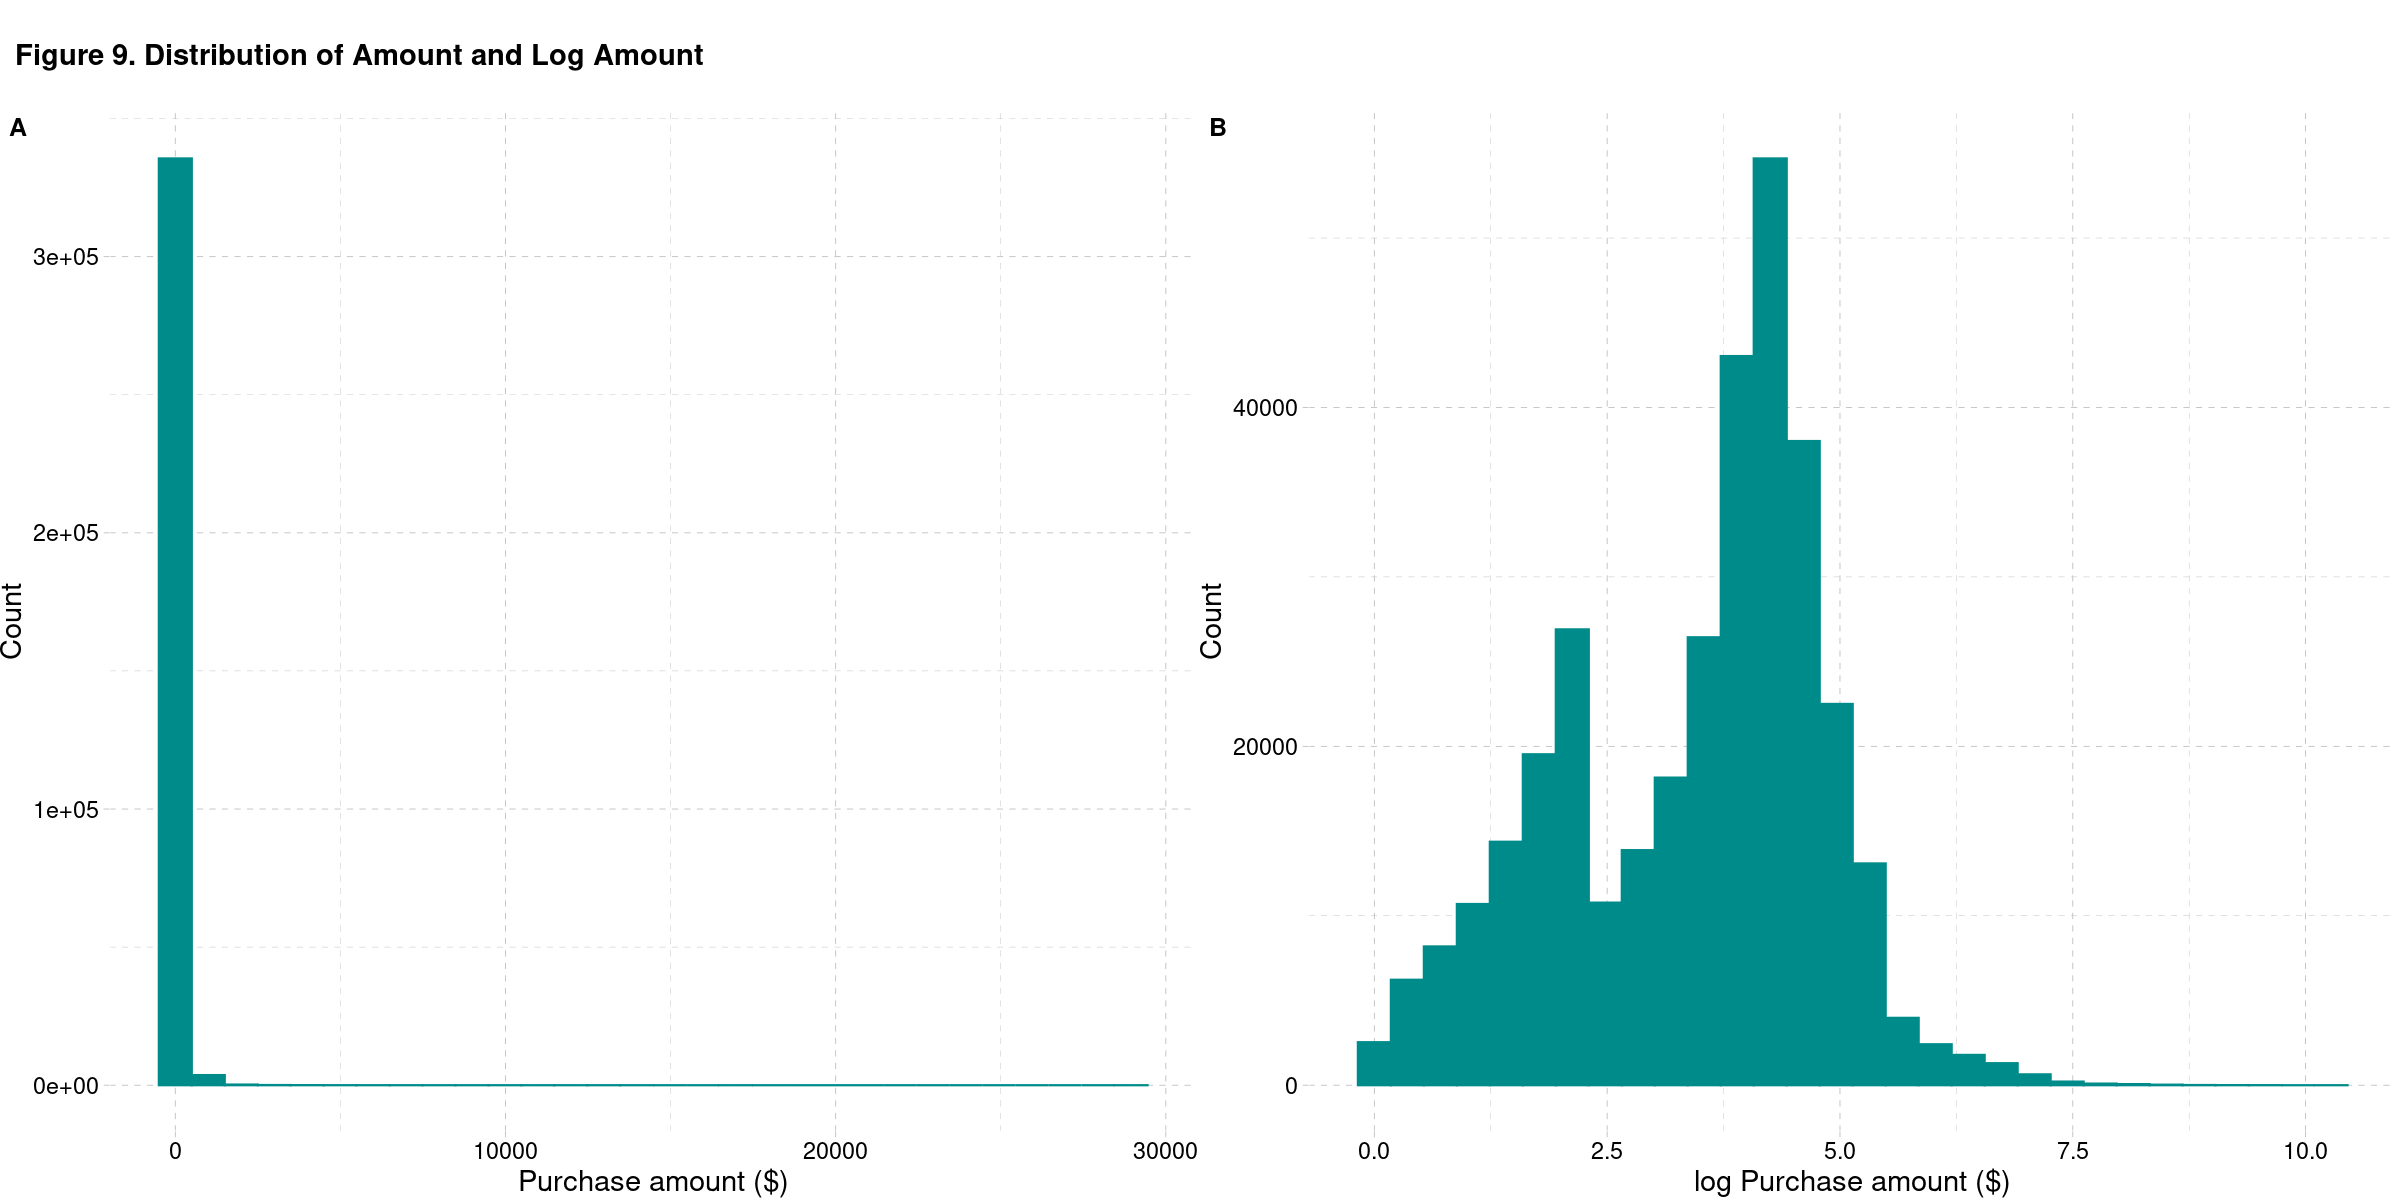

In [25]:
# Code Block 24:
p1 <- ggplot(fraud, aes(amt))+
geom_histogram(color= "darkcyan", fill = "darkcyan") +
#ggtitle("Figure 4: Amount of Transaction") +
ylab("Count") +
xlab("Purchase amount ($)") +
theme_pander(base_size = 14)

p2 <- ggplot(fraud, aes(log(amt)))+
geom_histogram(color= "darkcyan", fill = "darkcyan") +
#ggtitle("Figure 4: Amount of Transaction") +
ylab("Count") +
xlab("log Purchase amount ($)") +
theme_pander(base_size = 14)
#cowplots magic gridding, clearly needs work

plot_fig9 <- plot_grid(p1, p2, labels = c('A', 'B'), label_size = 12)
title9 <- ggdraw() + 
  draw_label(
    "Figure 9. Distribution of Amount and Log Amount",
    fontface = 'bold',
    x = 0,
    hjust = 0
  ) +
  theme(
    # add margin on the left of the drawing canvas,
    # so title is aligned with left edge of first plot
    plot.margin = margin(0, 0, 0, 7)
  )
plot_grid(
  title9, plot_fig9,
  ncol = 1,
  # rel_heights values control vertical title margins
  rel_heights = c(0.1, 1)
)



In [26]:
# Code Block 25:
fraud <- fraud %>%
mutate(amt_log = log(amt))

In [27]:
# Code Block 26:
#removed in related clusters, so easy to comment out if you want to add back a group

#remove amt and keep log transformed version
fraud <- fraud %>%
select(-amt)

#home location and home city pop shouldn't impact fraud
fraud <- fraud %>%
select(-city_pop, -lat_home, -long_home)

#remove date
fraud <- fraud %>% select(-date_only)

#remove jobs
fraud <- fraud %>%
select(-job)  #ideally I'd keep this in, but the fitting won't work with such a huge # of var

# 5 Final Preparation for Modeling

Code Block 26 removes some variables that I don't think will impact fraud- the population of the home city and the location of the home. I don't think the home should have an impact on fraud; it is where the card is used, not where it is billed, that should matter. I suppose you could have a neighborhood where all the mail was being stolen, and cards were compromised that way, but I think most cards get compromised at the point of sale. I also removed the date. The date itself is unlikely to be related to fraud. It is possible that special dates are correlated with fraud, like a holiday or a big sports match. There is a possibility that job type could have an impact on fraud- for example, a trucker might be more likely to have his/her card stolen just because they are always on the road and visiting a wide variety of places where they would use the card. Or this could come in as an interaction term with distance- distance from home and the occupation trucker might have no correlation, but the distance from home and the occupation teacher might have because it would be a more unusual event for that job.

However, the model fitting fails to converge when `job` is included, and it takes a long time for the models that it does work for.

In Code Block 27, I plot the correlation plot for the dataset. Highly correlated variables can cause problems for some fitting algorithms, again, especially for those coming from statistics. It also gives you a bit of a feel for what might come out of the model fitting. This is also a chance to do one last fact-check. For example, `category` and `amt` are reasonably correlated. The sign isn't particularly important in this case since `category` is arbitrarily ordered.

In Code Block 28, I make `is_fraud` a factor and relevel it per Tidymodels guidelines.

Lastly, in Code Block 29, I take a final look at the data and make sure I have the variables I expect.


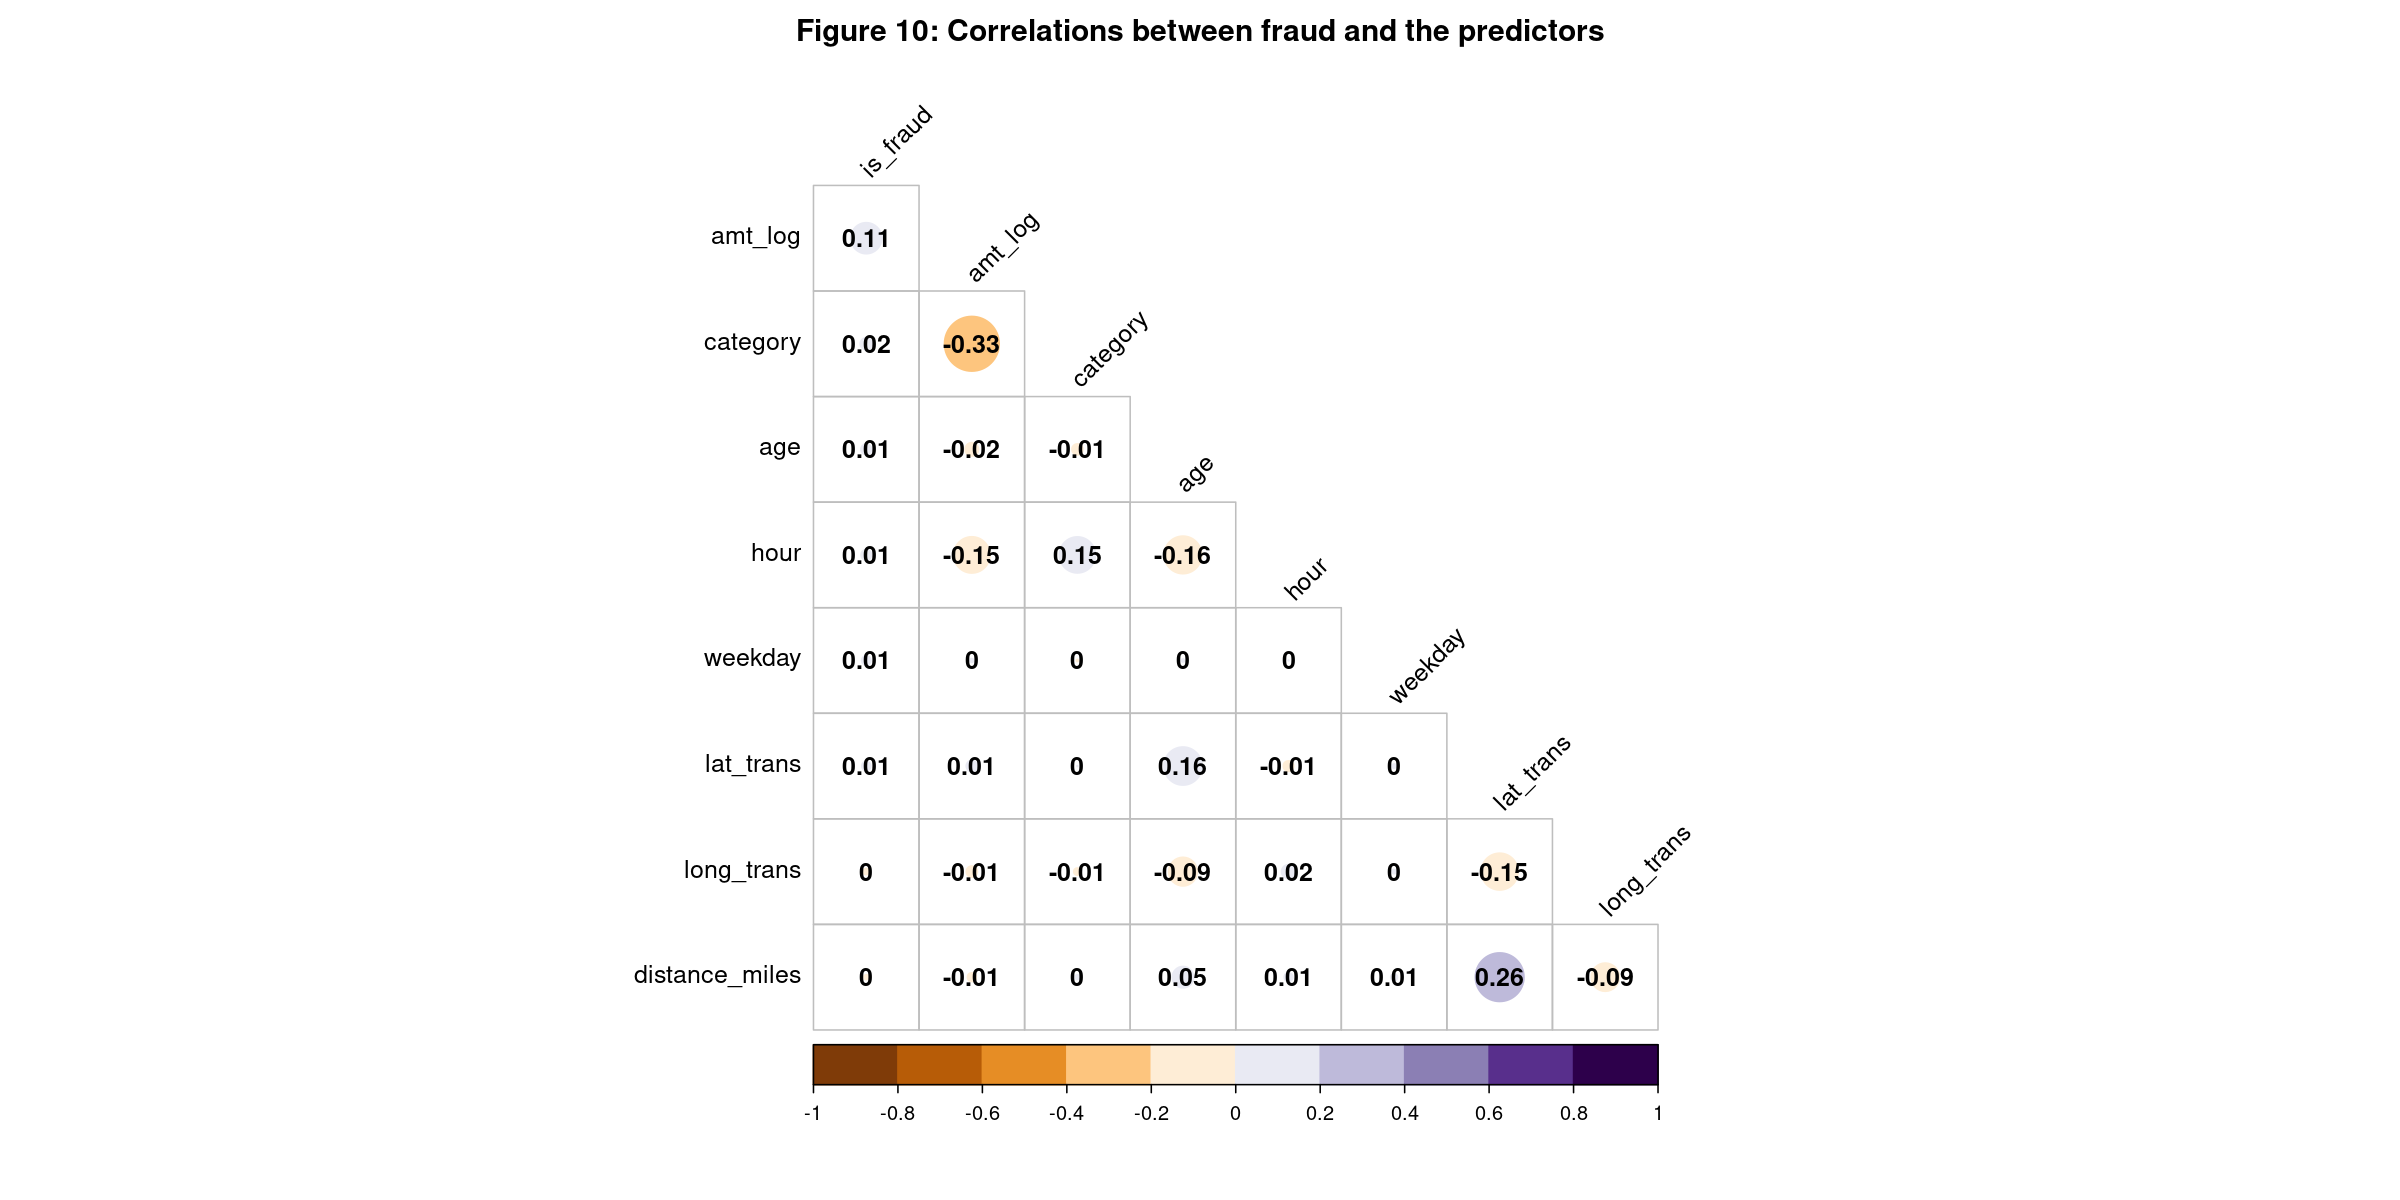

In [28]:
#Code Block 27: 
# examining correlation between variables with all property_type categories
#The correlation graph is arranged so that the outcome is the first column, and the rows are ordered from highest #correlation to lowest correlation with the outcome.

# solution for truncated title from  https://stefaneng.github.io/corrplot-title-cut-off/
fraud%>%
    mutate_if(is.factor, as.numeric) %>%
    dplyr::select(is_fraud, everything()) %>%
    cor %>%
    	{.[order(abs(.[, 1]), decreasing = TRUE), 
       order(abs(.[, 1]), decreasing = TRUE)]} %>%
	corrplot( type = 'lower', tl.col = 'black', addCoef.col = 'black',
         cl.ratio = 0.2, tl.srt = 45, col = COL2('PuOr', 10), diag = FALSE , mar=c(0,0,2,0), title = "Figure 10: Correlations between fraud and the predictors")

In [29]:
#Code Block 28: 

#in tidymodels, outcome should be a factor

fraud$is_fraud <- factor(fraud$is_fraud)

levels(fraud$is_fraud)


#first level is the event in tidymodels, so we need to reorder
# https://community.rstudio.com/t/tidymodels-which-factor-level-is-the-default-positive-class/100428
#https://medium.com/the-researchers-guide/modelling-binary-logistic-regression-using-tidymodels-library-in-r-part-1-c1bdce0ac055
fraud$is_fraud <- relevel(fraud$is_fraud, ref = "1")
levels(fraud$is_fraud)

[1] "0" "1"

[1] "1" "0"

In [30]:
#code Block 29: Viewing Final Fraud Dataset
glimpse(fraud)

Rows: 339,607
Columns: 9
$ category       <fct> grocery_pos, entertainment, grocery_pos, shopping_pos, …
$ lat_trans      <dbl> 48.8878, 42.1808, 41.6125, 32.9396, 43.0172, 20.0827, 4…
$ long_trans     <dbl> -118.2105, -112.2620, -122.5258, -105.8189, -111.0292, …
$ is_fraud       <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ distance_miles <dbl> 1271.5119381, 0.9433129, 2.3078189, 0.8747466, 2.499453…
$ age            <dbl> 40, 56, 73, 51, 51, 52, 73, 57, 31, 34, 42, 31, 63, 44,…
$ hour           <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1…
$ weekday        <dbl> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3…
$ amt_log        <dbl> 4.6749761, 5.3941274, 4.5673645, 2.0502702, 1.9242487, …


https://www.r-bloggers.com/2017/04/dealing-with-unbalanced-data-in-machine-learning/

## 6 Model Fitting
There are two main goals of the model fitting section.  The first (6.1) is to actually produce a high performing model for the data using the workflow_set functionality of tidymodels.  The second (6.2) is to understand the various methods of fitting and predicting within the tidymodels framework.

## 6.1 Finding a high performing model

I'm planning to study the following models and methods of handled imbalanced class problems.
* Explore different classification models
    - logistic regression
    - elastic net logistic regression
    - lightgbm
    - random forest
* Explore Different method of handling imbalanced class problems
    - do nothing
    - SMOTE
    - ROSE
    - downsample

This ends up being 4 x 4 different fits, and keeping track of all the combinations can become difficult. Luckily, tidymodels has a function workflow_set that will create all the combinations and workflow_map to run all the fitting procedures.

First, preparation work for both sections. In Code Block 30, I split the data into a testing and training set. I also create folds for cross-validation from the training set.


In [31]:
# Code Block 30 : Train/Test Splits & CV Folds 

# Split the data into a test and training set
# following https://www.tidymodels.org/start/recipes/#recipe

set.seed(222)
data_split <- initial_split(fraud, prop = 0.75, stata = is_fraud)     

# Create data frames for the two sets:
train_data <- training(data_split)
test_data  <- testing(data_split)

start_time <- Sys.time()

set.seed(123)
fraud_folds <- vfold_cv(train_data, v= 3, strata = is_fraud)
#fraud_folds

end_time <- Sys.time()
print("Making folds: ")
end_time - start_time

[1] "Making folds: "


Time difference of 0.1212237 secs

Next, I create recipes in Code Block 31. I do some preprocessing of the data- making dummy variables, normalizing, and removing variables that only contain one value (`step_zv(all_predictors()) `). The processing will be applied to both the training and testing data as you move through the workflow.

I used the chart found in [Appendix A]([url](https://www.tmwr.org/pre-proc-table.html)) of the Tidy Modeling with R by Max Kuhn and Julia Silge to choose the preprocessing of data. Some models require specific types of preprocessing, others don't require it, but it can produce better or faster fitting, and in other cases, the preprocessing isn't required and probably doesn't help. The chart breaks this down for each category of preprocessing model by model. The same preprocessing steps were required or recommended for the models I chose, so I used them across the board. You can create recipes for different models and build a workflow manually to match the models to the proper recipe. This process is covered extensively in [Chapter 15]([url](https://www.tmwr.org/workflow-sets.html)) of Tidy Modeling with R.

I use the selector functions (`all_nominal_predictors()`, `all_numerical_predictors()`, etc.) available in the tidymodels framework. A listing of all selector functions useable in tidymodels can be found [here]([url](https://recipes.tidymodels.org/reference/selections.htm)). Using selector functions when handling groups of features reduces the chance of mistakes and typos.

I then modify this recipe to handle the imbalanced class problem. I use SMOTE and ROSE hybrid methods to balance the classes. These methods create synthetic data for the minority class and downsample the majority class to balance the classes. I also use downsample, which throws away majority class records to balance the two classes. A good overview is [here]([url](https://www.r-bloggers.com/2019/04/methods-for-dealing-with-imbalanced-data/)), and it also provides a tutorial for handling this type of problem with caret, rather than tidy models.

In [32]:
# Code Block 31: recipes

recipe_plain <- 
  recipe(is_fraud ~ ., data = train_data) %>%
  step_dummy(all_nominal_predictors()) %>%
  step_normalize(all_numeric_predictors()) %>%
  step_zv(all_predictors()) 

recipe_rose <- 
recipe_plain %>%
   step_rose(is_fraud)

recipe_smote <- 
recipe_plain %>%
  step_smote(is_fraud)

recipe_down <- 
recipe_plain %>%
  step_downsample(is_fraud)


Next, I set the engines for the models I use in Code Block 32. I tune the hyperparameters of the elastic net logistic regression and the lightgbm. Random Forest also has tuning parameters, but the random forest model is pretty slow to fit, and adding tuning parameters makes it even slower. If none of the other models worked well, then tuning RF would be a good idea.

In [33]:
# Code Block 32: Setting engines

#this is the standard logistic regression
logreg_spec <- 
  logistic_reg() %>% 
  set_engine("glm")

#elastic net regularization of logistic regression
#this has 2 hyperparameters that we will tune
glmnet_spec <- 
  logistic_reg(penalty = tune(),
               mixture = tune()) %>%
  set_engine("glmnet")

#random forest also has tunable hyperparameters, but for the sake of speed, we won't 
rf_spec <- 
  rand_forest(trees = 100) %>% 
  set_engine("ranger") %>% 
  set_mode("classification")

#This is a boosted gradient method with 6 tuning parameters
lightgbm_spec <-
  boost_tree(mtry = tune(), trees = tune(), tree_depth = tune(), 
  learn_rate = tune(), min_n =tune(), loss_reduction = tune()) %>%
  set_engine(engine = "lightgbm", importance = "impurity_corrected") %>%
  set_mode(mode = "classification")


Lastly, I create a metrics set in Code Block 33. Accuracy is generally a terrible metric for highly imbalanced problems; the model can achieve high accuracy by assigning everything to the majority class. Alternate metrics like [sensitivity]([url](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)) or [j-index]([url](https://en.wikipedia.org/wiki/Youden%27s_J_statistic)) are better choices for the imbalanced class situation.

In [34]:
# Code Block 33: Setting Metrics

fraud_metrics <- metric_set(roc_auc, accuracy, sensitivity, specificity, j_index)

In Code Block 34, I create the workflow_set. This is where tidymodels shines. I feed it the 4 recipes and the 4 engines, and it makes all the permutations to fit. (Again, you can manually create a workflow_set where you assign specific recipes to specific models, but here all recipes work with all models.)

In [35]:
# Code block 34: 
wf_set_tune <-
  workflow_set(
    list(plain = recipe_plain,
         rose = recipe_rose, 
        smote = recipe_smote,
        down = recipe_down),
    list(glmnet = glmnet_spec, lightgmb = lightgbm_spec, logreg = logreg_spec, rf = rf_spec)
  )


In Code Block 35, I now run these 16 models. I pass `workflow_map()` the workflow_set from Code Block 34. The next parameter is what type of fitting you want to do. Here, I used `tune_grid` and had it generate 6 grid points. For the models that don't require hyperparameter tuning, the function defaults to `fit_resamples` instead. The acceptable types of fitting functions are found [here]https://workflowsets.tidymodels.org/reference/workflow_map.html. It is important to note that you can only use fitting methods that operate on folds; you cannot pass `workflow_map()` the entire train or test set and have it work. This caused me a bit of frustration when I was learning this because I wanted to compare the results I got from `workflow_map()` to process all the models simultaneously to what I got when I ran each model/recipe separately. It is implemented this way to encourage proper methodology and avoid data leakage. When evaluating multiple models, you should not be evaluating with the entire dataset.

In [36]:
# Code block 35: 
start_time <- Sys.time()
set.seed(345)
tune_results <- 
  workflow_map(
    wf_set_tune,
    "tune_grid",
    resamples = fraud_folds,
    grid = 6,
    metrics = fraud_metrics,
      verbose = TRUE,  #this gives details about how long each model/recipe takes
      control = control_grid(save_pred = TRUE)
  )

#tune_rs  #this causes a lot of notebooks to time out. 

end_time <- Sys.time()
      print("Total Time for this Set: ")
end_time - start_time

i  1 of 16 tuning:     plain_glmnet

✔  1 of 16 tuning:     plain_glmnet (50.5s)

i  2 of 16 tuning:     plain_lightgmb

i Creating pre-processing data to finalize unknown parameter: mtry

✔  2 of 16 tuning:     plain_lightgmb (2m 47.3s)

i	No tuning parameters. `fit_resamples()` will be attempted

i  3 of 16 resampling: plain_logreg

✔  3 of 16 resampling: plain_logreg (8.9s)

i	No tuning parameters. `fit_resamples()` will be attempted

i  4 of 16 resampling: plain_rf

✔  4 of 16 resampling: plain_rf (1m 46.5s)

i  5 of 16 tuning:     rose_glmnet

✔  5 of 16 tuning:     rose_glmnet (1m 14.9s)

i  6 of 16 tuning:     rose_lightgmb

i Creating pre-processing data to finalize unknown parameter: mtry

✔  6 of 16 tuning:     rose_lightgmb (7m 21.3s)

i	No tuning parameters. `fit_resamples()` will be attempted

i  7 of 16 resampling: rose_logreg

✔  7 of 16 resampling: rose_logreg (12.9s)

i	No tuning parameters. `fit_resamples()` will be attempted

i  8 of 16 resampling: rose_rf

✔  8 of 1

[1] "Total Time for this Set: "


Time difference of 49.15173 mins

I viewed the results of the fitting as both a table (Code Block 36) and graphically using `autoplot()` (Code Block 37). The autoplot legend is unclear, so you'll want to do both, as I did. The legend doesn't label by recipe (only that a recipe was used for preprocessing) and folds related categories into one. Here you see that elastic net logistic regression and logistic regression are both labeled log_reg.

The object we have now, `tune_results`, is incredibly large and complicated. I saw tutorials using RStudio that viewed this object, so I originally included that in my code. Don't do that! It will cause your notebook to time out as it tries to figure out how to display it. I've also managed to crash RStudio by attempting to view this type of object, though RStudio generally handles it better. I wanted to explore this object to understand it, but I ended up burning through a lot of time with notebooks endlessly running. I placed it immediately after `workflow_map()`, so I assumed it was the fitting that was timing out. I used a ton of `sys.time()` variables to figure out where things were going wrong. The best way to handle this object type is to use the provided helper functions.

This `tune_results` object contains information we need to move forwards. The best hyperparameters are in here... somewhere.

In [37]:
# Code Block 35
rank_results(tune_results, rank_metric = "j_index")

wflow_id,.config,.metric,mean,std_err,n,preprocessor,model,rank
<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<int>
down_lightgmb,Preprocessor1_Model6,accuracy,0.9639819,0.0023334654,3,recipe,boost_tree,1
down_lightgmb,Preprocessor1_Model6,j_index,0.9193192,0.0068910915,3,recipe,boost_tree,1
down_lightgmb,Preprocessor1_Model6,roc_auc,0.9917846,0.0004710462,3,recipe,boost_tree,1
down_lightgmb,Preprocessor1_Model6,sensitivity,0.9552940,0.0074067787,3,recipe,boost_tree,1
down_lightgmb,Preprocessor1_Model6,specificity,0.9640252,0.0023586720,3,recipe,boost_tree,1
down_rf,Preprocessor1_Model1,accuracy,0.9558431,0.0029547378,3,recipe,rand_forest,2
down_rf,Preprocessor1_Model1,j_index,0.9074127,0.0041514254,3,recipe,rand_forest,2
down_rf,Preprocessor1_Model1,roc_auc,0.9876995,0.0008825251,3,recipe,rand_forest,2
down_rf,Preprocessor1_Model1,sensitivity,0.9515485,0.0030958242,3,recipe,rand_forest,2


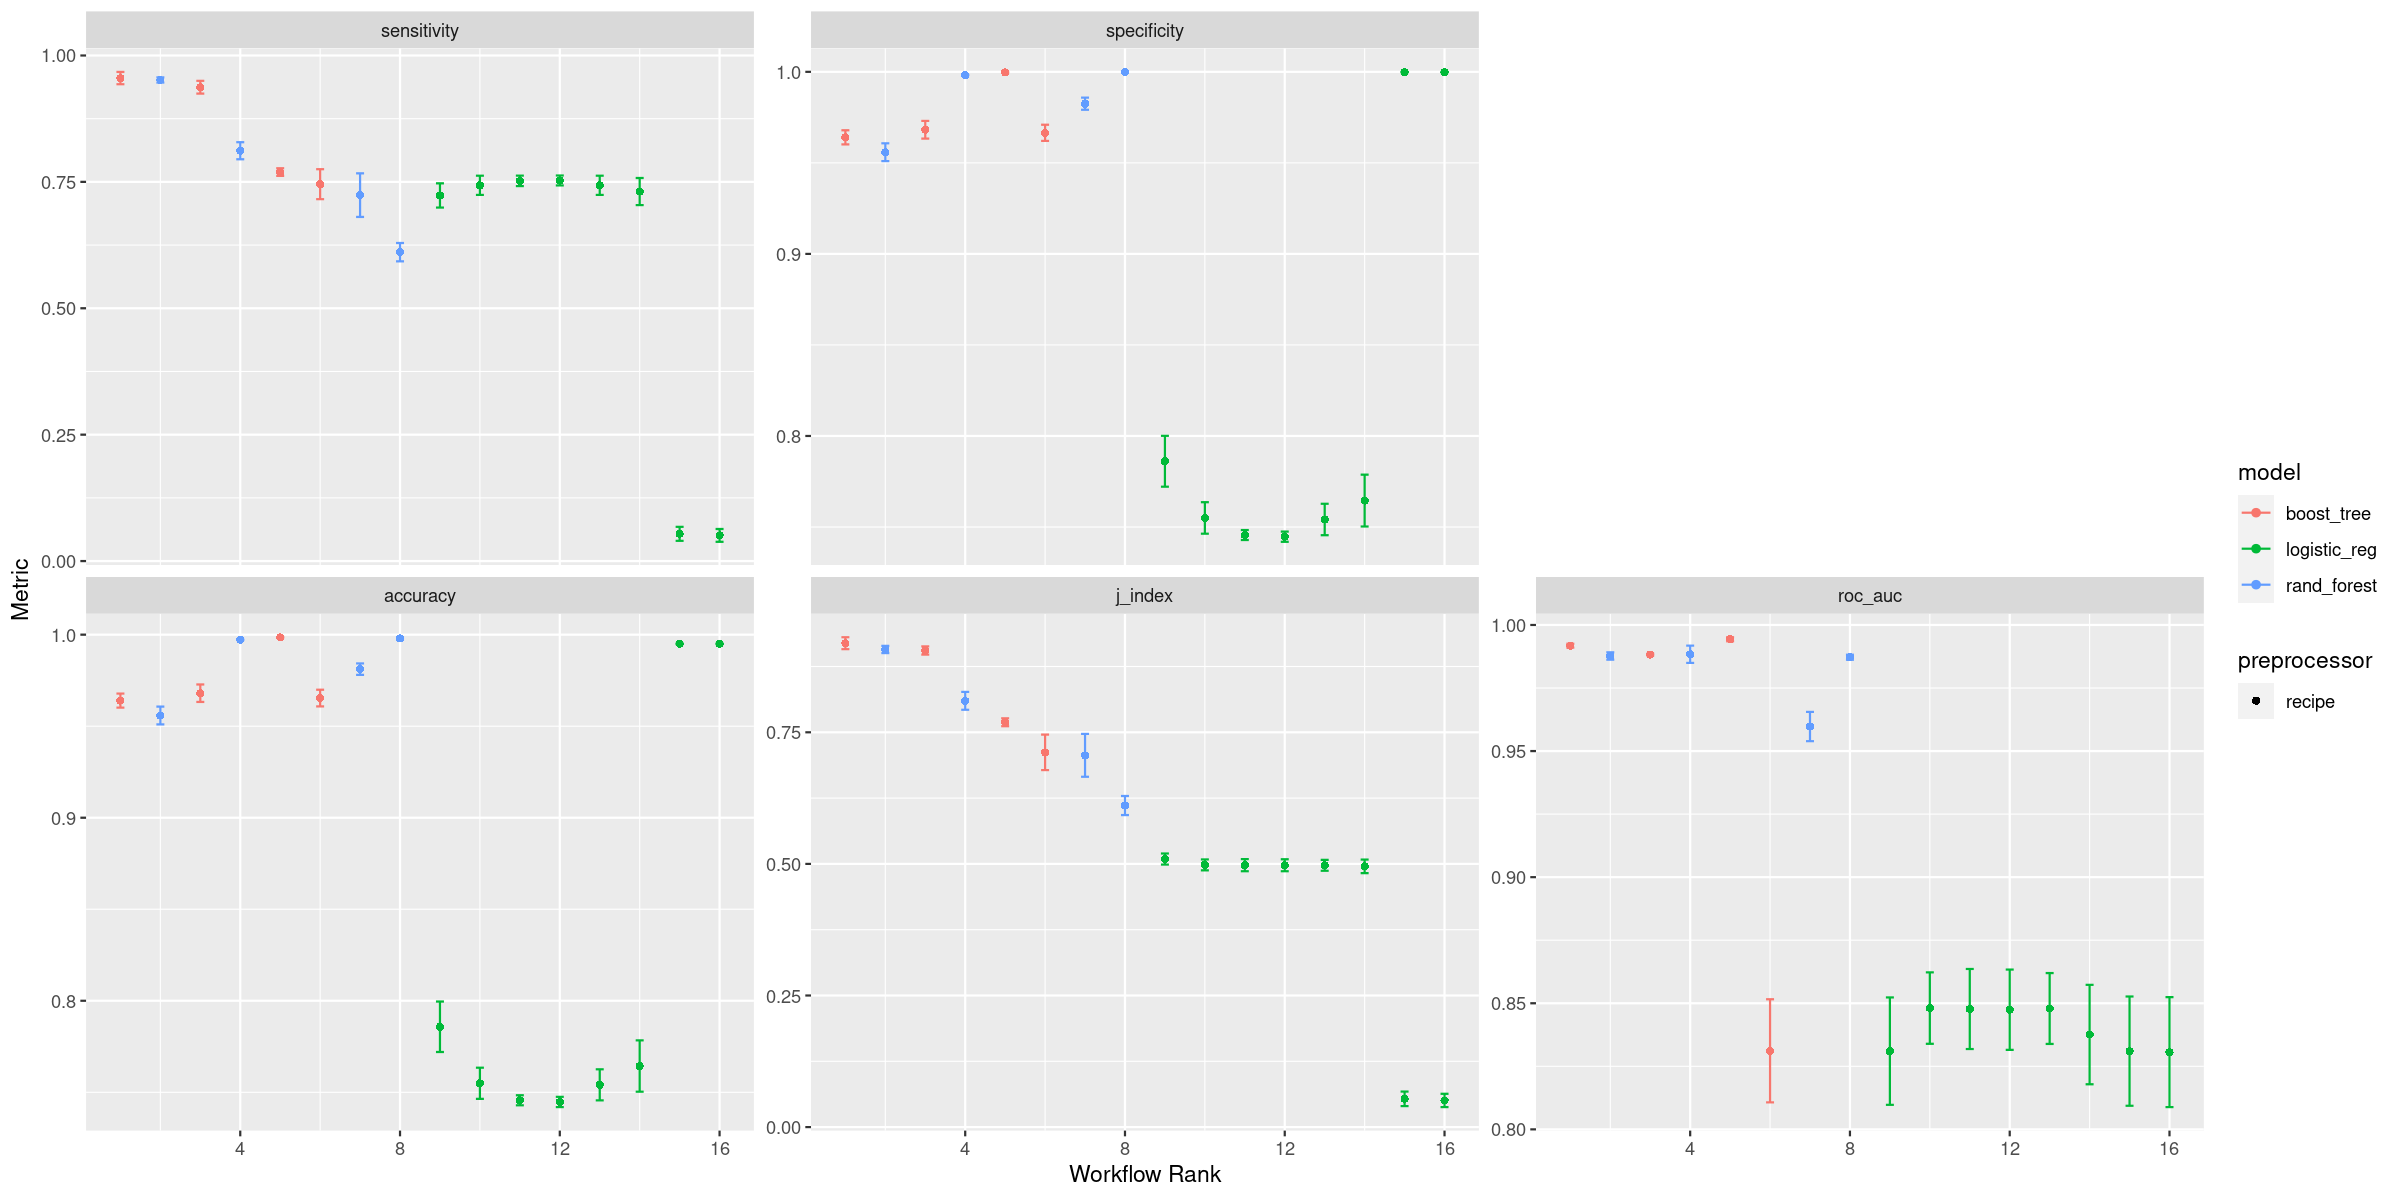

In [38]:
# Code Block 36
autoplot(tune_results, rank_metric = "j_index", select_best = TRUE)

This `tune_results` object contains information we need to move forwards.  The best hyperparameters are in here... somewhere.  From Code Block 35, we see the best performing model / recipe pair by j-index is the downsampled lightgmb (`down_lightgmb`).

To see how this model/recipe performs across tuning parameters, we can use `extract_workflow_set_result` and autoplot it, as in Code Block 37.  If you wanted to refine the hyperparameters more, you could use these results to narrow the search parameters to areas with the best performance.  In this case, I'm just going to extract the best set of hyperparameters and move on.  This is done in Code Block 38, using the same `extract_workflow_set_result` and `select_best(metric = "j_index")`.  There are other ways to choose the model; for example you could choose the simplest models that was withing 1 standard deviation of the best model.  The list of selectors is found [here]([url](https://tune.tidymodels.org/reference/show_best.html)).  If you look at what is produced, Code Block 39, we see it is the hyperparameters and details about which model it is.

Now, I am going to use the convenience functions finalize_workflow() and last_fit() to add [the best hyperparameters to the workflow]([url](https://tune.tidymodels.org/reference/finalize_model.html)), [train the model/recipe on the entire training set, and then predict on the entire test set]([url](https://tune.tidymodels.org/reference/last_fit.html)).  There is a lot of stuff going on here at once (Code Block 40)! 

The object that results from `last_fit()` is again a complex object, and will be discussed in detail in section 6.2.  For now, we can look at the metrics and ROC curve for the test data, Code Block 41.

Just for fun, let's see how much money this model would have save our credit card compay, Code Block 42.  I'm going to assume the cost of fraud is the cost of the transaction.  I calculate the total cost of all the fraudulent transactions in the test dataset.  I then calculate the cost based on the model predictions.  Any truly fraudulent transactions that were not caught, cost the value of the transaction.  Legitimate transactions that were marked as fraud were assigned $0 cost.  This likely isn't true.  There is the cost of having to deal with customers calling because the transaction was declined or the cost sending out texts for suspicious transactions, but this cost is very small relative to the cost of a fraudulent transaction.  I got the idea from a paper by:

My model had dramatic costs savings for the imaginary credit card company!  The losses from the model were 25% of the potential losses.

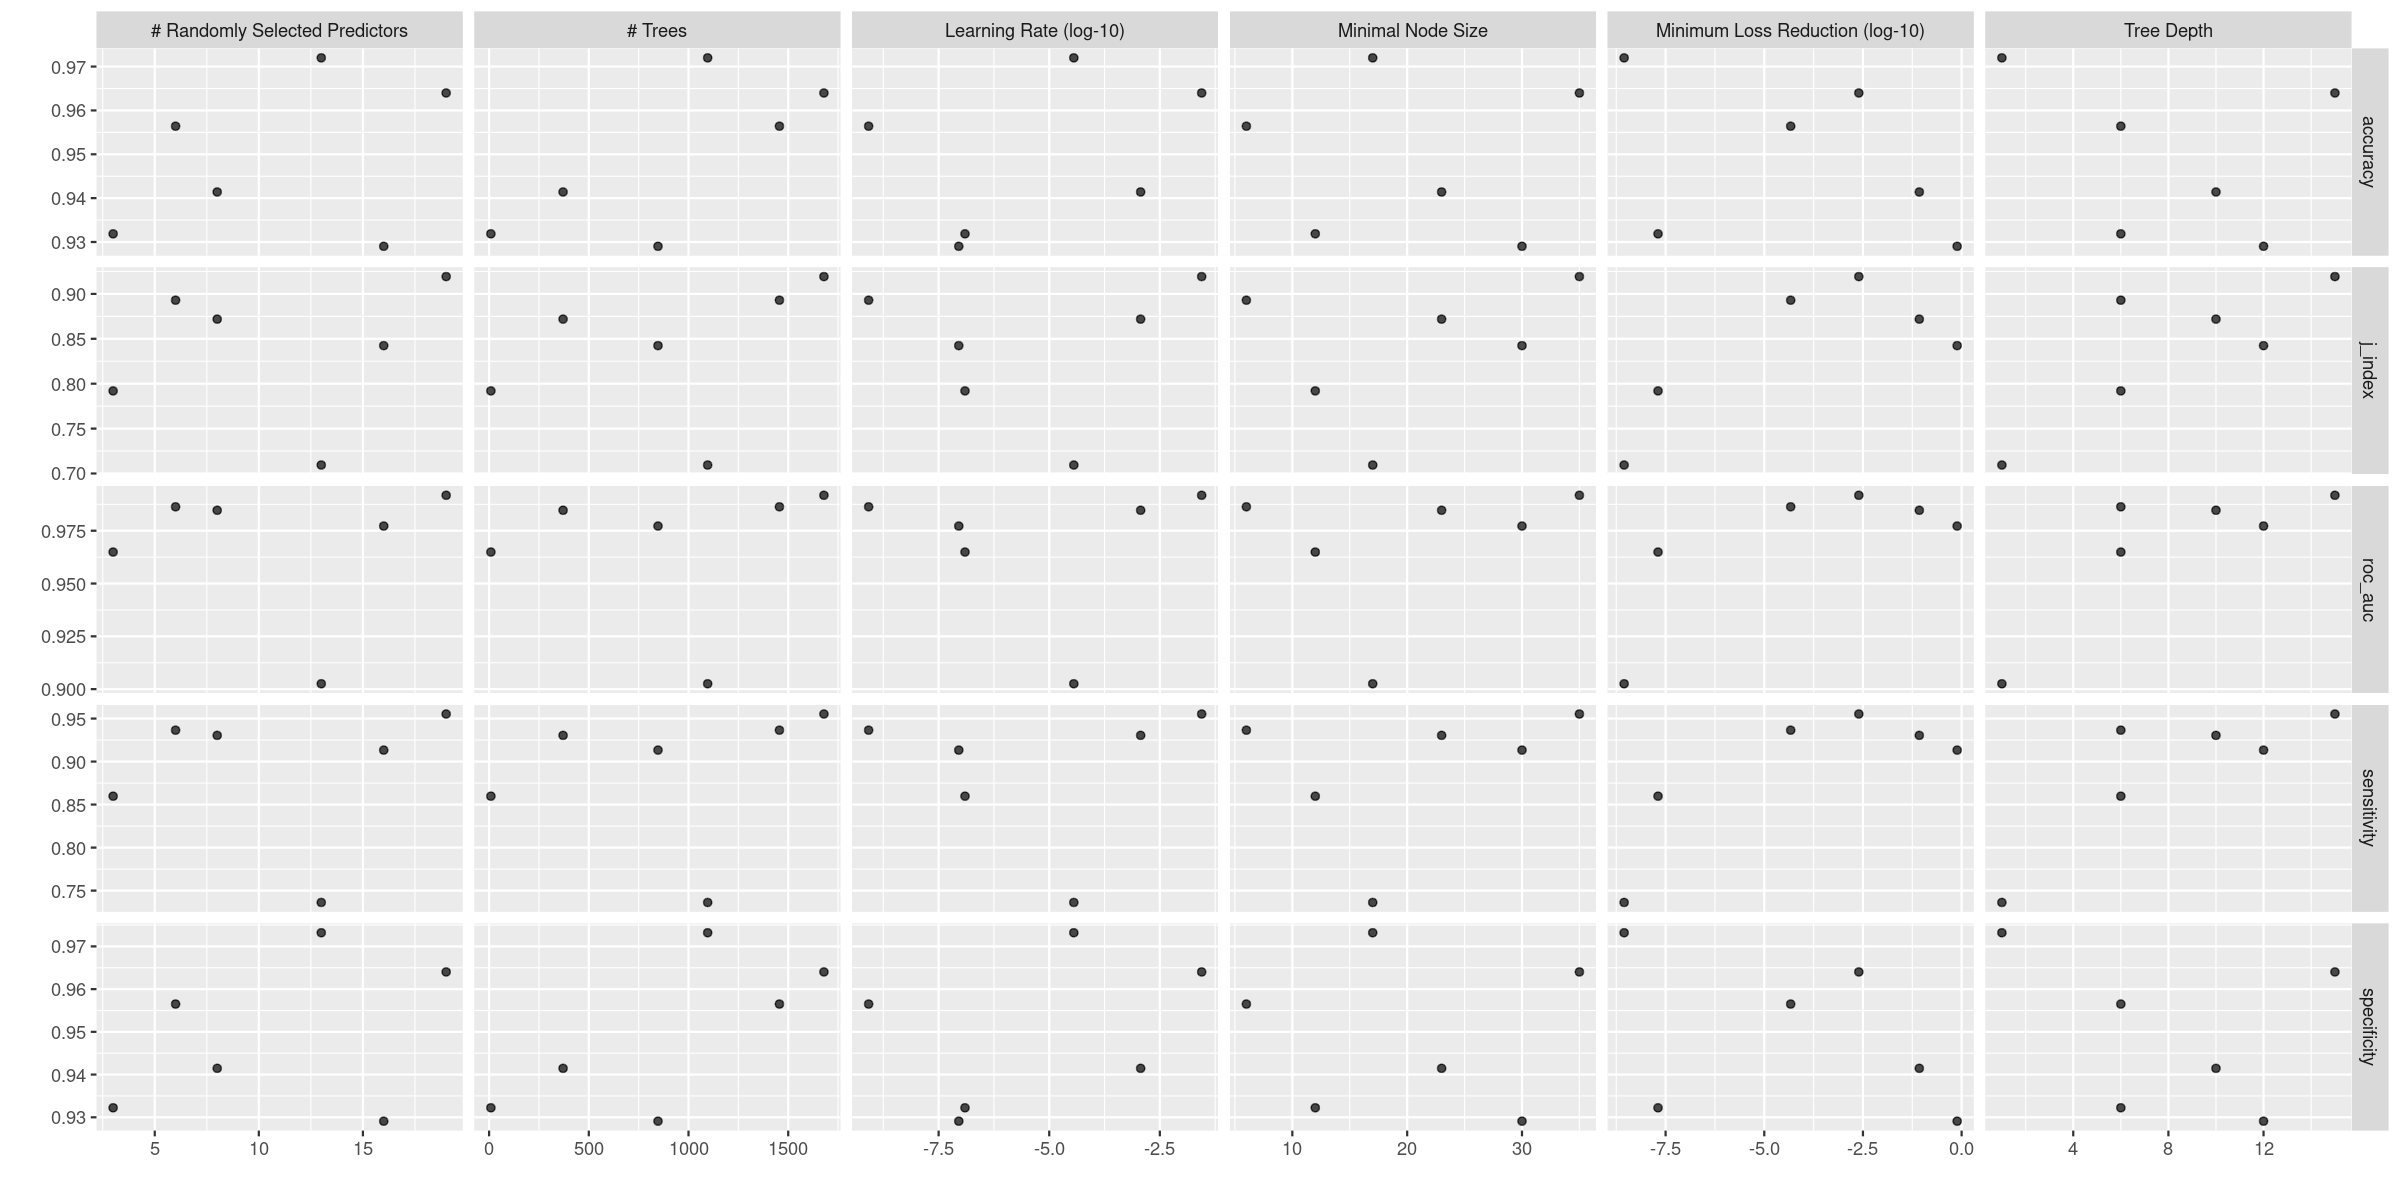

In [39]:
# Code block 37: 

results_down_gmb <- tune_results %>% 
    extract_workflow_set_result("down_lightgmb")
autoplot(results_down_gmb)

In [40]:
# Code block 38: 
best_results_down_gmb <- tune_results %>% 
    extract_workflow_set_result("down_lightgmb") %>%
    select_best(metric = "j_index")

In [41]:
# Code block 39: 
print(best_results_down_gmb)

# A tibble: 1 × 7
   mtry trees min_n tree_depth learn_rate loss_reduction .config             
  <int> <int> <int>      <int>      <dbl>          <dbl> <chr>               
1    19  1679    35         15     0.0279        0.00249 Preprocessor1_Model6


In [42]:
# Code Block 40: Validating the model with the test data
validation_results <- tune_results %>%
  extract_workflow("down_lightgmb") %>%
  finalize_workflow(best_results_down_gmb) %>%
  last_fit(split =  data_split, metrics = fraud_metrics)

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.9612494,Preprocessor1_Model1
sensitivity,binary,0.9604167,Preprocessor1_Model1
specificity,binary,0.9612542,Preprocessor1_Model1
j_index,binary,0.9216708,Preprocessor1_Model1
roc_auc,binary,0.9926503,Preprocessor1_Model1


Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.
ℹ The deprecated feature was likely used in the yardstick package.
  Please report the issue at <https://github.com/tidymodels/yardstick/issues>.”


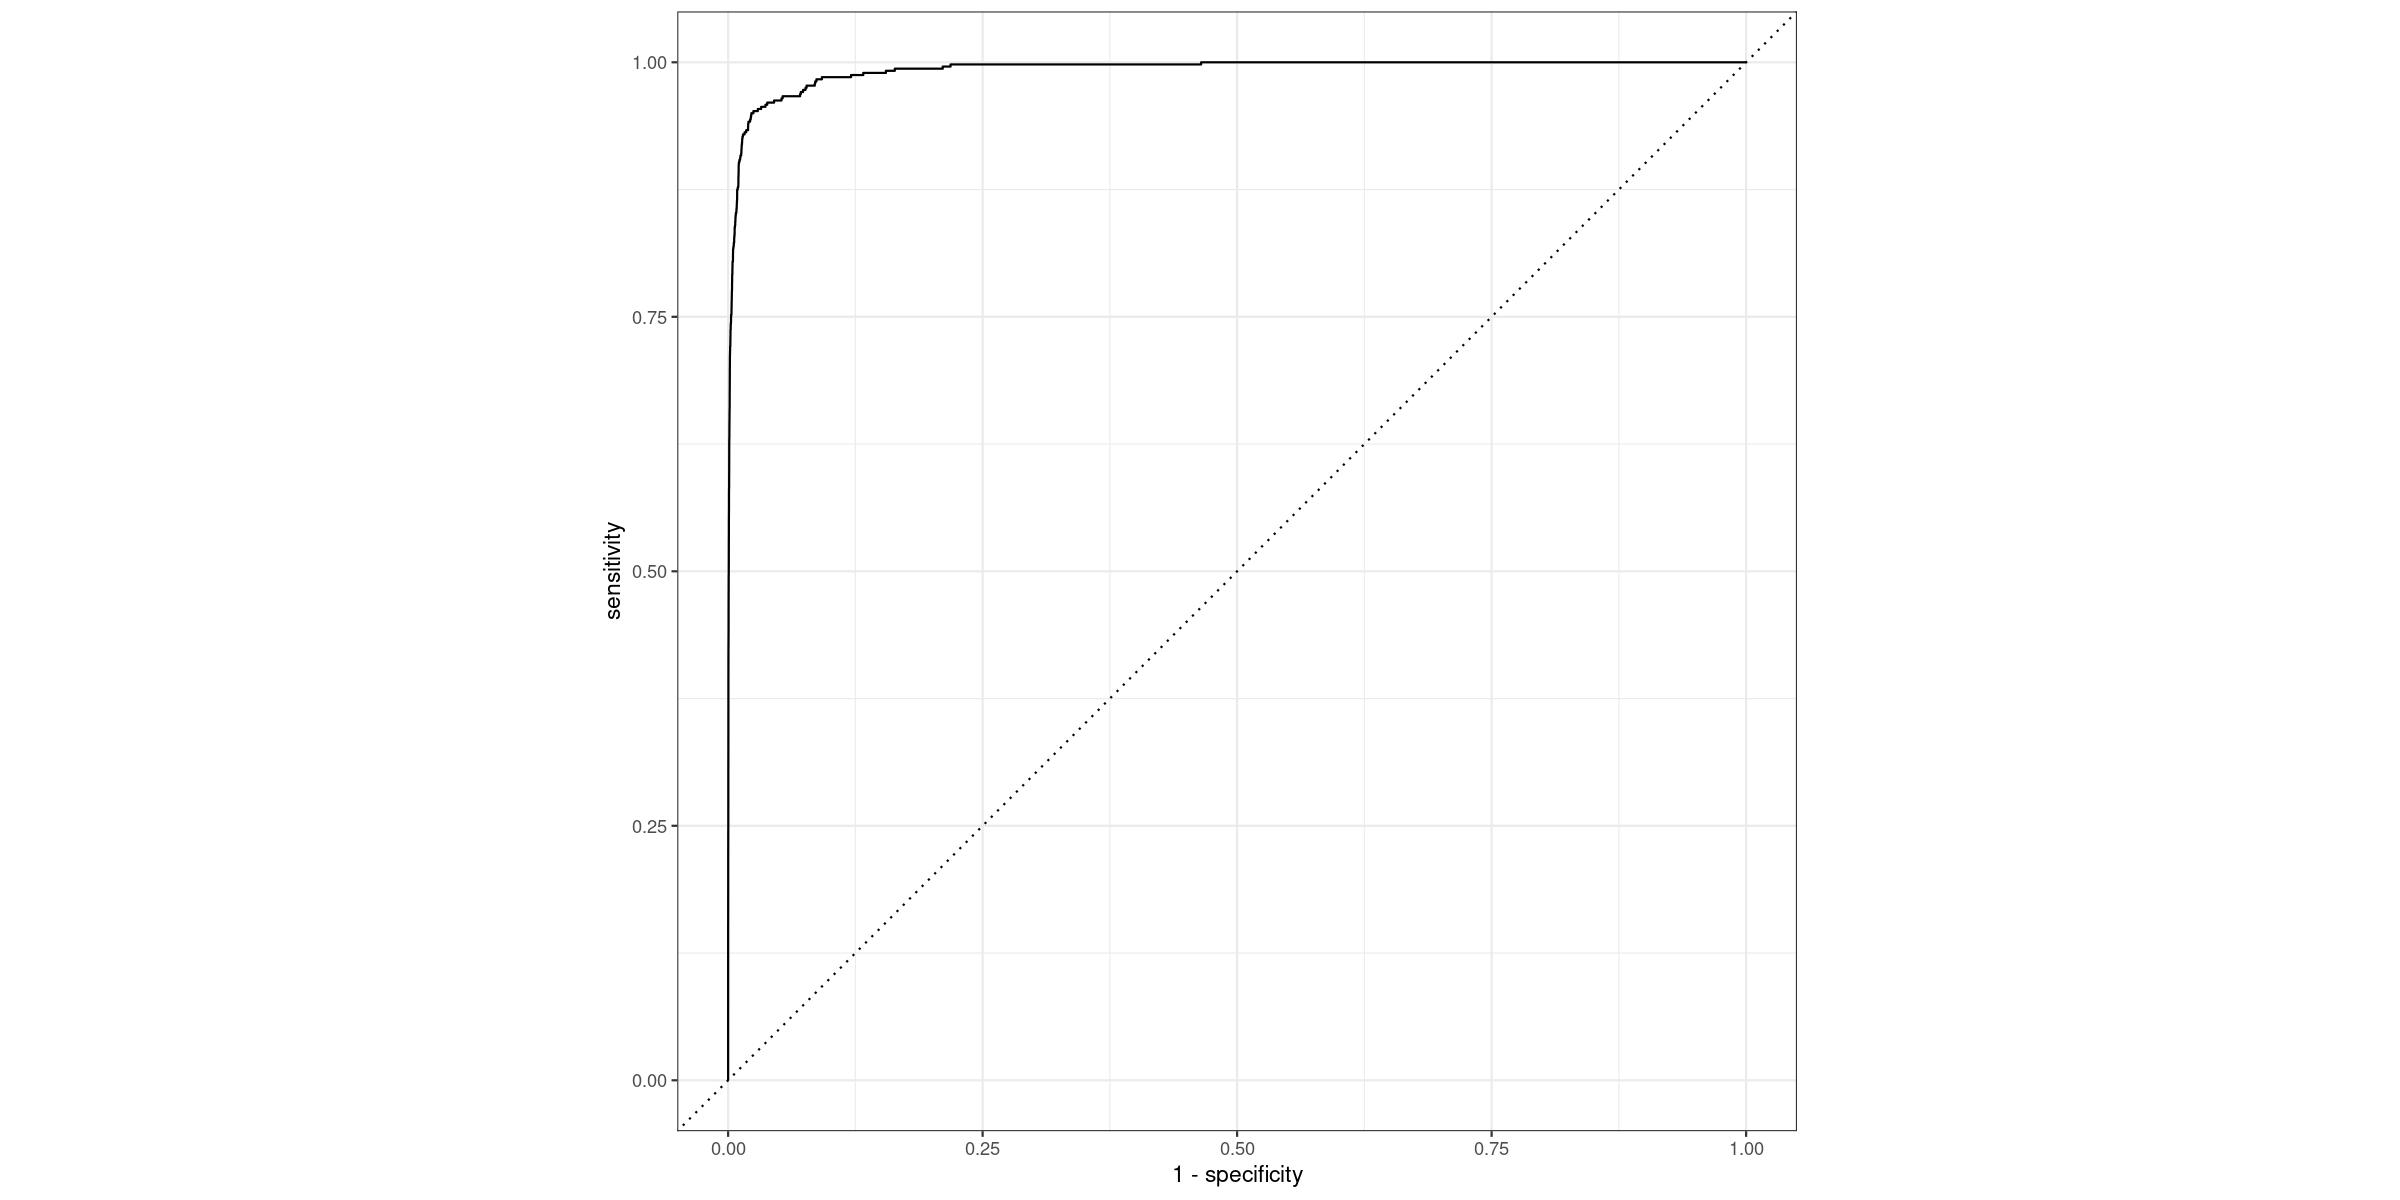

In [43]:
# Code Block 41: Looking at the validation metrics from the test data.
collect_metrics(validation_results)

validation_results %>% 
  collect_predictions() %>% 
  roc_curve(is_fraud, .pred_1) %>% 
  autoplot()

In [44]:
#code block 42: Calculating how much fraud cost the company

val <- validation_results[[5]][[1]]

val %>% conf_mat(truth = is_fraud, estimate = .pred_class)
val <- val %>% rename(is_fraud2  = is_fraud)  #I'm going to bind this to the test data and I want unique names
#glimpse(val)

cost <- test_data %>%
cbind(val)

cost <- cost %>%
select(is_fraud, amt_log, pred = .pred_class, is_fraud2) #is_fraud is the true, is_fraud2 is the prediction

cost <- cost %>%
mutate(cost_act = ifelse((is_fraud ==1 & pred == 0), amt_log, 0)) %>%   #cost for missing fraud in prediction
mutate(cost_potential = ifelse((is_fraud ==1), amt_log, 0)) #cost of all fraud

sum(exp(cost$cost_act))
sum(exp(cost$cost_potential))

sum(exp(cost$cost_act))/sum(exp(cost$cost_potential))

          Truth
Prediction     1     0
         1   461  3271
         0    19 81151

[1] 85961.79

[1] 331533.4

[1] 0.2592854

## 6.2: Understanding the different ways to fit in Tidymodels

The main source of my considerable confusion was that I expected `fit`, `last_fit`, `fit_resamples`, etc., to all produce objects that contained the same information and could be acted on by the same functions. This is not the case. If you already understand this, then this section can be skipped. Otherwise, I will delve into the functions and the objects they create in detail.
 
I'm going to use the splits, folds, recipes, and engines I created for 6.1.

Objectives:
Understand the difference in the output of fit/predict and last_fit.  
Learn how to extract the information from the output of fit/predict and last_fit/
Understand the difference in the output of fit_resamples and fit.
Learn how to extract the information from the output of fit_resamples and fit.



The modeling process involves fitting (or training) the model on the training set and then applying that fit to the test dataset. This can be accomplished in one of two ways- via the pair of commands `fit`/`predict` or the single function `fit_last`.

The method using `fit`/`predict` takes the workflow and the training data and creates the trained parsnip fit object. This object is then passed to predict along with the test data and returns the predictions for the test data ONLY (Code Block 31). Note that fit does not take a metrics set (unlike the other functions I will discuss) and defaults to returning hard classification predictions. You can pass predict type = "prob" to get the probabilities instead.


`wflow_fit <- fit(wf_simple, data = train_data)`

`wflow_predict <- predict(wflow_fit, new_data = test_data)`

`wflow_predict` is a vector of predictions with no other information (Code Block 32).  
The output of the fit is more complicated. Code Block 34 shows `head(wflow_fit)`. The output shows various components to the object: the recipe, a tibble with the processed train_data (`$mold$predictors`), a tibble of outcomes, the results of the fit (parsnip model object), and others. The structure of this object is shown in Code Block 35, which reveals the highly nested nature of this object. Calling `wflow_fit` in some environments will cause the notebook to time out. This seems to now be fixed in the Datacamp workspace; the call now returns the same output as `head(wflow_fit)`.  

While you can use standard R operations for interacting with lists and nested data to extract the desired information from wflow_fit, it is much easier to use the [broom package](https://broom.tidymodels.org/). Broom is part of the core tidymodels installation, so it does not need to be installed separately. To get the model coefficients and p-values in tibble form, use `tidy()`. For high-level statistics about the model, use glance(). Just remember that the information you extract from the output of `fit()` relates to the model as applied to the training data. For information about the model performance as applied to the test data, you need to use the output of `predict()`. Since this output is only a vector of predictions, you need to bind it to the test dataframe and then perform analysis on the new object.

It is more convenient then to use `last_fit()` instead of `fit()` & `predict()`. The function `last_fit()` is passed the workflow object and the data split object (that is, the object with the test and train splits) and fits the model on the training data, and then uses the trained model to predict the test data. The output can then be interacted with using a variety of helper functions like `collect_metrics()`. You can also extract the predictions for the test data and compare them with the results generated from predict() and see that they are identical (Code Block XX). Similarly, the fit data generated from training on the train data can be extracted from the last_fit object via `extract_fit_parsnip()`. The model coefficients can also be extracted via `tidy()`, and you can see that they are the same as those produced by using the fit function.

Importantly, `last_fit()` can be passed a metrics set. For classification problems, if the metrics set contains metrics that need probabilities, the predictions will contain both the class prediction and the probabilities. This can be useful if you want to soft classification. If the metrics set includes only metrics, such as accuracy, that use class predictions, then the probabilities will not be returned.


In [45]:
# Code block 43: Create simple workflow to Compare Fit/Predict and last_fit
wf_simple <-
  workflow() %>%
  add_recipe(recipe_plain) %>%
  add_model(logreg_spec)


In [46]:
# Code block 44: Run fit/ predict

wflow_fit <- fit(wf_simple, data = train_data)
wflow_predict <- predict(wflow_fit, new_data = test_data)


In [47]:
# Code block 45:  Examine the outcome of predict
head(wflow_predict)

.pred_class
<fct>
0
0
0
0
0
0


In [48]:
# Code block 46: 
wflow_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: logistic_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_dummy()
• step_normalize()
• step_zv()

── Model ───────────────────────────────────────────────────────────────────────

Call:  stats::glm(formula = ..y ~ ., family = stats::binomial, data = data)

Coefficients:
            (Intercept)                lat_trans               long_trans  
               7.047329                -0.088772                -0.019071  
         distance_miles                      age                     hour  
               0.037784                -0.297104                -0.856000  
                weekday                  amt_log     category_food_dining  
              -0.119246                -1.830993                -0.011626  
 category_gas_transport     category_grocery_net     category_grocery_pos  
              -0.691083   

In [49]:
# # Code block 47: 
head(wflow_fit)



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 8



── Operations 

• Dummy variables from: all_nominal_predictors()

• Centering and scaling for: all_numeric_predictors()

• Zero variance filter on: all_predictors()



$pre
$actions
$actions$recipe
$recipe

$blueprint
Recipe blueprint: 
 
# Predictors: 0 
  # Outcomes: 0 
   Intercept: FALSE 
Novel Levels: FALSE 
 Composition: tibble 

attr(,"class")
[1] "action_recipe" "action_pre"    "action"       


$mold
$mold$predictors
# A tibble: 254,705 × 20
   lat_trans long_trans distanc…¹     age   hour weekday amt_log categ…² categ…³
       <dbl>      <dbl>     <dbl>   <dbl>  <dbl>   <dbl>   <dbl>   <dbl>   <dbl>
 1   0.152       1.48      -0.283  0.338  -1.59    1.60  -1.06    -0.269  -0.341
 2  -0.328      -0.913     -0.290  0.750   1.50   -1.29   0.820   -0.269  -0.341
 3   1.12       -0.952     -0.288 -0.604  -0.119  -0.805 -0.265   -0.269  -0.341
 4   0.262       0.0368    -0.286 -0.545  -0.706  -1.29   0.0153  -0.269  -0.341
 5  -0.732       0.360     -0.288 -0.0156 -0.853   1.60   0.395   -0.269  -0.341
 6   0.00455     1.34      -0.290 -0.0156  1.50    0.635  2.18    -0.269  -0.341
 7  -0.784       0.205     -0.270 -1.02   -0.999   0.155  0.631  

In [50]:
# Code block 48: 
str(wflow_fit)

List of 4
 $ pre    :List of 3
  ..$ actions     :List of 1
  .. ..$ recipe:List of 2
  .. .. ..$ recipe   :List of 7
  .. .. .. ..$ var_info    : tibble [9 × 4] (S3: tbl_df/tbl/data.frame)
  .. .. .. .. ..$ variable: chr [1:9] "category" "lat_trans" "long_trans" "distance_miles" ...
  .. .. .. .. ..$ type    :List of 9
  .. .. .. .. .. ..$ : chr [1:3] "factor" "unordered" "nominal"
  .. .. .. .. .. ..$ : chr [1:2] "double" "numeric"
  .. .. .. .. .. ..$ : chr [1:2] "double" "numeric"
  .. .. .. .. .. ..$ : chr [1:2] "double" "numeric"
  .. .. .. .. .. ..$ : chr [1:2] "double" "numeric"
  .. .. .. .. .. ..$ : chr [1:2] "integer" "numeric"
  .. .. .. .. .. ..$ : chr [1:2] "double" "numeric"
  .. .. .. .. .. ..$ : chr [1:2] "double" "numeric"
  .. .. .. .. .. ..$ : chr [1:3] "factor" "unordered" "nominal"
  .. .. .. .. ..$ role    : chr [1:9] "predictor" "predictor" "predictor" "predictor" ...
  .. .. .. .. ..$ source  : chr [1:9] "original" "original" "original" "original" ...
  .. .. .

In [51]:
# Code block 49: 
wflow_fit %>% tidy() #summarizes information about model components



term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),7.047328624,0.06970956,101.09558781,0.000000e+00
lat_trans,-0.088771520,0.03077424,-2.88460487,3.919052e-03
long_trans,-0.019071477,0.03080104,-0.61918286,5.357959e-01
distance_miles,0.037783858,0.03057990,1.23557840,2.166153e-01
age,-0.297103905,0.02898236,-10.25119625,1.168878e-24
hour,-0.855999576,0.04019949,-21.29378942,1.296120e-100
weekday,-0.119246291,0.02909912,-4.09793507,4.168522e-05
amt_log,-1.830992976,0.05085756,-36.00237849,7.678250e-284
category_food_dining,-0.011626488,0.06316663,-0.18406060,8.539659e-01


In [52]:
# Code block 50: 
wflow_fit %>% glance() #reports information about the entire model

null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
16336.57,254704,-5879.636,11801.27,12020.68,11759.27,254684,254705


In [53]:
# Code block 51: 
#last_fit_results <- last_fit(wflow_fit, data_split, metrics = fraud_metrics)

fraud_metrics_hard <- metric_set(accuracy)
last_fit_results <- last_fit(wflow_fit, data_split, metrics = fraud_metrics_hard)
last_fit_pred <- last_fit_results[[5]][[1]]

#https://github.com/tidymodels/tune/issues/300




In [54]:
# Code block 52: 
head(last_fit_pred)

.pred_class,.row,is_fraud,.config
<fct>,<int>,<fct>,<chr>
0,1,0,Preprocessor1_Model1
0,2,0,Preprocessor1_Model1
0,8,0,Preprocessor1_Model1
0,12,0,Preprocessor1_Model1
0,13,0,Preprocessor1_Model1
0,14,0,Preprocessor1_Model1


In [55]:
# Code block 53: 
head(wflow_predict)

.pred_class
<fct>
0
0
0
0
0
0


In [56]:
# Code block 54: 
identical(last_fit_pred$.pred_class, wflow_predict$.pred_class) 

[1] TRUE

In [57]:
# Code block 55: 
last_fit_results %>% collect_metrics()

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.9946173,Preprocessor1_Model1


In [58]:
# Code block 56: 
last_fit_results %>% extract_fit_parsnip() %>% tidy()

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),7.047328624,0.06970956,101.09558781,0.000000e+00
lat_trans,-0.088771520,0.03077424,-2.88460487,3.919052e-03
long_trans,-0.019071477,0.03080104,-0.61918286,5.357959e-01
distance_miles,0.037783858,0.03057990,1.23557840,2.166153e-01
age,-0.297103905,0.02898236,-10.25119625,1.168878e-24
hour,-0.855999576,0.04019949,-21.29378942,1.296120e-100
weekday,-0.119246291,0.02909912,-4.09793507,4.168522e-05
amt_log,-1.830992976,0.05085756,-36.00237849,7.678250e-284
category_food_dining,-0.011626488,0.06316663,-0.18406060,8.539659e-01
